集成广义线性贝叶斯，调整模型权重，效果优于传统广义线性BN方法
---
Bagging+Bayesian：论文用
---

In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
from theano import shared
import pandas as pd
from matplotlib import gridspec
from sklearn.decomposition import PCA, KernelPCA
from DataSplit import *
from PCA import *
from RMSE import *

D:\Softwares\Python\Python_Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.style.use('default')
font1 ={'family': 'times new roman', 'weight':'light', 'size': 12}  
# font2 ={'family': 'Arial', 'weight':'normal', 'size': 12}  
def Plot_XZ(elec_year, elec_faults, Savefig):
# 画出原始图
    Company_names = ['Xizang', 'Xinjiang', 'Heilongjiang']
    k = np.array([0, 41, 83])
    j= 0
    # j, k1 = 0, 6
    plt.figure(figsize=(4, 3), facecolor='w')

    ax = plt.subplot(1, 1, 1)
    for jx in range(7):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016', '2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[0]], loc='upper left', frameon=False, fontsize='small')
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\New12\\Yuanshi1.png', dpi = 200, bbox_inches='tight')
    plt.show()
    plt.figure(figsize=(4, 3), facecolor='w')

    ax = plt.subplot(1, 1, 1)
    for jx in range(7, 14, 1):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016','2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[1]], loc='upper left', frameon=False, fontsize='small')
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\New12\\Yuanshi2.png', dpi = 200, bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(4, 3), facecolor='w')
    ax = plt.subplot(1, 1, 1)
    for jx in range(14, 21, 1):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016','2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[2]], loc='upper left', frameon=False, fontsize='small')
#     leg = plt.legend()
#     leg.get_frame().set_linewidth(0.0)
    
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\New12\\Yuanshi3.png', dpi = 200, bbox_inches='tight')
    plt.show()
    return 0

(126, 4)


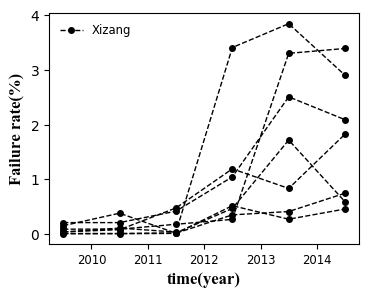

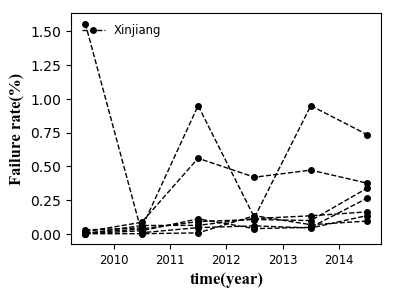

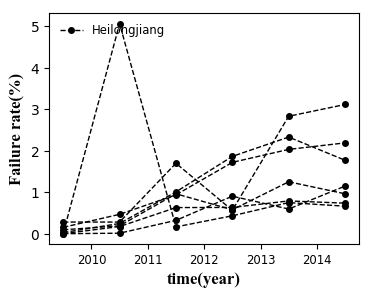

In [3]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储

elec_data = pd.read_csv('XZmulti_6.csv')


# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同
# elec_count = elec_data.counts.values

# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 2, size=[len(elec_data.Year.values), 4])
SNR_Tem = np.random.normal(0, 1, size=[len(elec_data.Year.values), 1])
# #特征因素分析

elec_tem = elec_data.Tem.values + SNR_Tem[:, 0] # 观测温度值x2
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 1]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 2] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
elec_Lux = elec_data.Lux.values + SNR[:, 3] # 观测压强x3
elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)


# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)
data_cs_year = elec_year
Add_year_Mean = np.mean(elec_year)
elec_year_Mean = (elec_year - np.mean(elec_year)) #均值化后的时间点
elec_year = elec_year_Mean
# print(elec_year)

elec_Pca = np.vstack((elec_tem1, elec_hPa1, elec_RH1, elec_Lux1)).T   # 特征数据合并为一个数组
print(np.shape(elec_Pca))
# np.savetxt('elec_Pca.csv', elec_Pca, delimiter = ',')
# =============================================================================================
# # PCA特征降维，减少相关性，有两种方法，一种是自带函数，一种是网上程序，下面注释为网上程序
# x, z= pcaa(elec_Pca);  XX = np.array(x); ZZ = np.array(z)
# 将温度等4个特征降维变成2个特征，贡献率为99%以上，满足信息要求; 转换后的特征经过模型后能否还原
# =============================================================================================
# #白化，使得每个特征具有相同的方差，减少数据相关性，n_components：控制特征量个数
pca = PCA(n_components=2)
pca.fit(elec_Pca)
# 将数据X转换成降维后的数据。当模型训练好后，对于新输入的数据，都可以用transform方法来降维。
elec_Pca1 = pca.transform(elec_Pca)
elec_Pca1 = np.array(elec_Pca1)

elec_Pca_char1 = elec_Pca1[:, 0] # 降维特征1
elec_Pca_char2 = elec_Pca1[:, 1] # 降维特征2
# elec_Pca_char1 = np.loadtxt('elec_Pca_char1.csv',delimiter = ',')
# elec_Pca_char2 = np.loadtxt('elec_Pca_char2.csv',delimiter = ',')

elec_data.Fault.values[48] =1200
elec_data.Fault.values[85] =700
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults = 100 * (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
# elec_faults1 = (elec_faults - np.mean(elec_faults)) / np.std(elec_faults)

# 将故障率以6组一行形式组成数组,变成：21*6
elec_faults2 = np.array([elec_faults[i*6:(i+1)*6] for i in np.arange(21)])
elec_year2 = np.array([elec_year[i*6:(i+1)*6] for i in np.arange(21)])
elec_char1 = np.array([elec_Pca_char1[i*6:(i+1)*6] for i in np.arange(21)])
elec_char2 = np.array([elec_Pca_char2[i*6:(i+1)*6] for i in np.arange(21)])
companyABC2 = np.array([companyABC[i*6:(i+1)*6] for i in np.arange(21)])

# 共享变量设置
xs_char1 = shared(np.asarray(elec_Pca_char1))
xs_char2 = shared(np.asarray(elec_Pca_char2))

ys_faults = shared(np.asarray(elec_faults))
xs_year = shared(np.asarray(elec_year))
Num_shared = shared(np.asarray(companyABC))
# 画图
Plot_XZ(elec_year2, elec_faults2, Savefig)

def logit(x):
    return 1/(1+np.exp(-x))
def tlogit(x):
    return 1/(1+tt.exp(-x))
def Phi(x):
    # probit transform
    return 0.5 + 0.5 * pm.math.erf(x/pm.math.sqrt(2))

Bayesian  子模型1
---

[ 1  4 11 13 14 20]
(90, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[-2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.]


Average Loss = 82.475: 100%|████████████████████████████████████████████████████| 20000/20000 [00:28<00:00, 707.15it/s]
Finished [100%]: Average Loss = 82.48
Average Loss = 82.308: 100%|███████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1134.52it/s]
Finished [100%]: Average Loss = 82.275
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Assigned BinaryGibbsMetropolis to zij
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [02:48<00:00, 20.81it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.6176335706979831, but should be close to 0.8. Try to in

WAIC_r(WAIC=0.6880534831168061, WAIC_se=32.27820522326285, p_WAIC=16.721882722132968)
0.6880534831168061


D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\stats.py:285: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO_r(LOO=7.413536641490546, LOO_se=33.11832992158615, p_LOO=20.08462430131984)


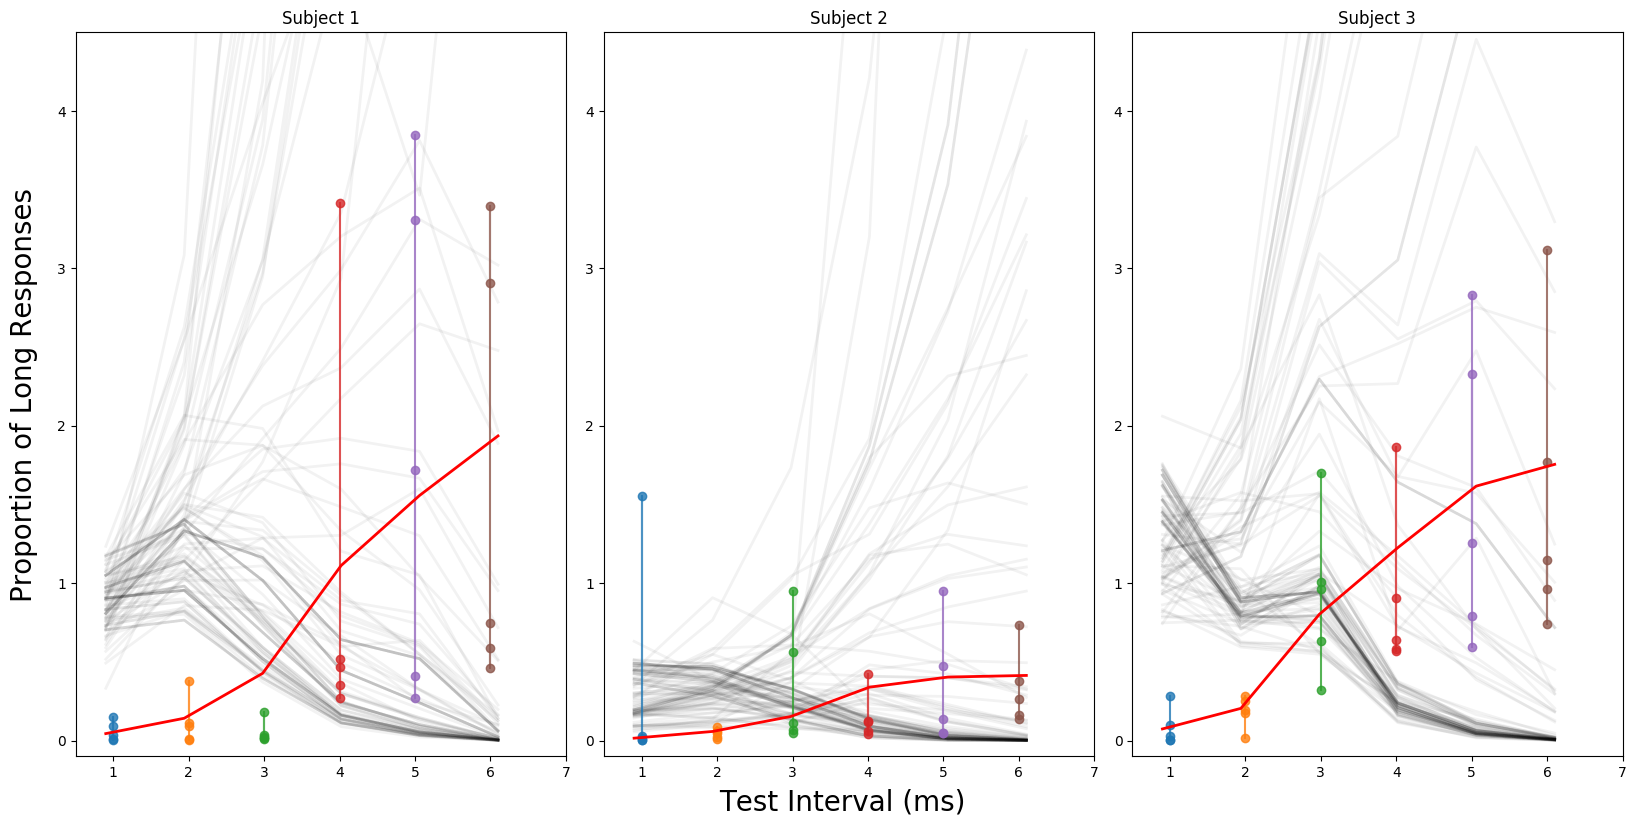

[-3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.
  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.
  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.
  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.
  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2.]
90
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2754.95it/s]


[0. 0. 0. 1. 1. 2. 3.]


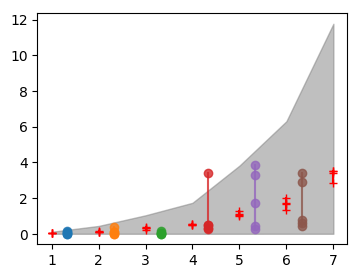

[0. 0. 0. 0. 0. 0. 1.]


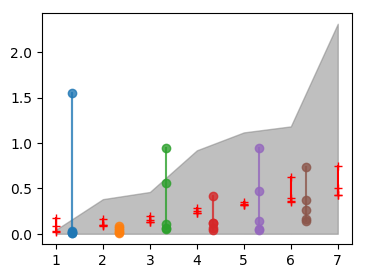

[0. 0. 0. 1. 2. 3. 2.]


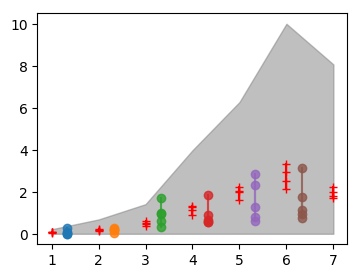

[[0. 0. 0. 1. 1. 2. 3.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 2. 3. 2.]]
0
[ 0  4  7 12 18 19]
(90, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[-2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.]


Average Loss = 82.742: 100%|████████████████████████████████████████████████████| 20000/20000 [00:27<00:00, 726.85it/s]
Finished [100%]: Average Loss = 82.771
Average Loss = 82.073: 100%|███████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1114.44it/s]
Finished [100%]: Average Loss = 82.023
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Assigned BinaryGibbsMetropolis to zij
100%|█████████████████████████████████████████████████████████████████████████████▉| 3499/3500 [03:06<00:00, 18.74it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 316 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (se

WAIC_r(WAIC=-7.645625190155211, WAIC_se=35.671338811118815, p_WAIC=16.741762225098224)
-7.645625190155211


D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\stats.py:285: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO_r(LOO=-1.292385933940035, LOO_se=37.06659299385138, p_LOO=19.918381853205823)


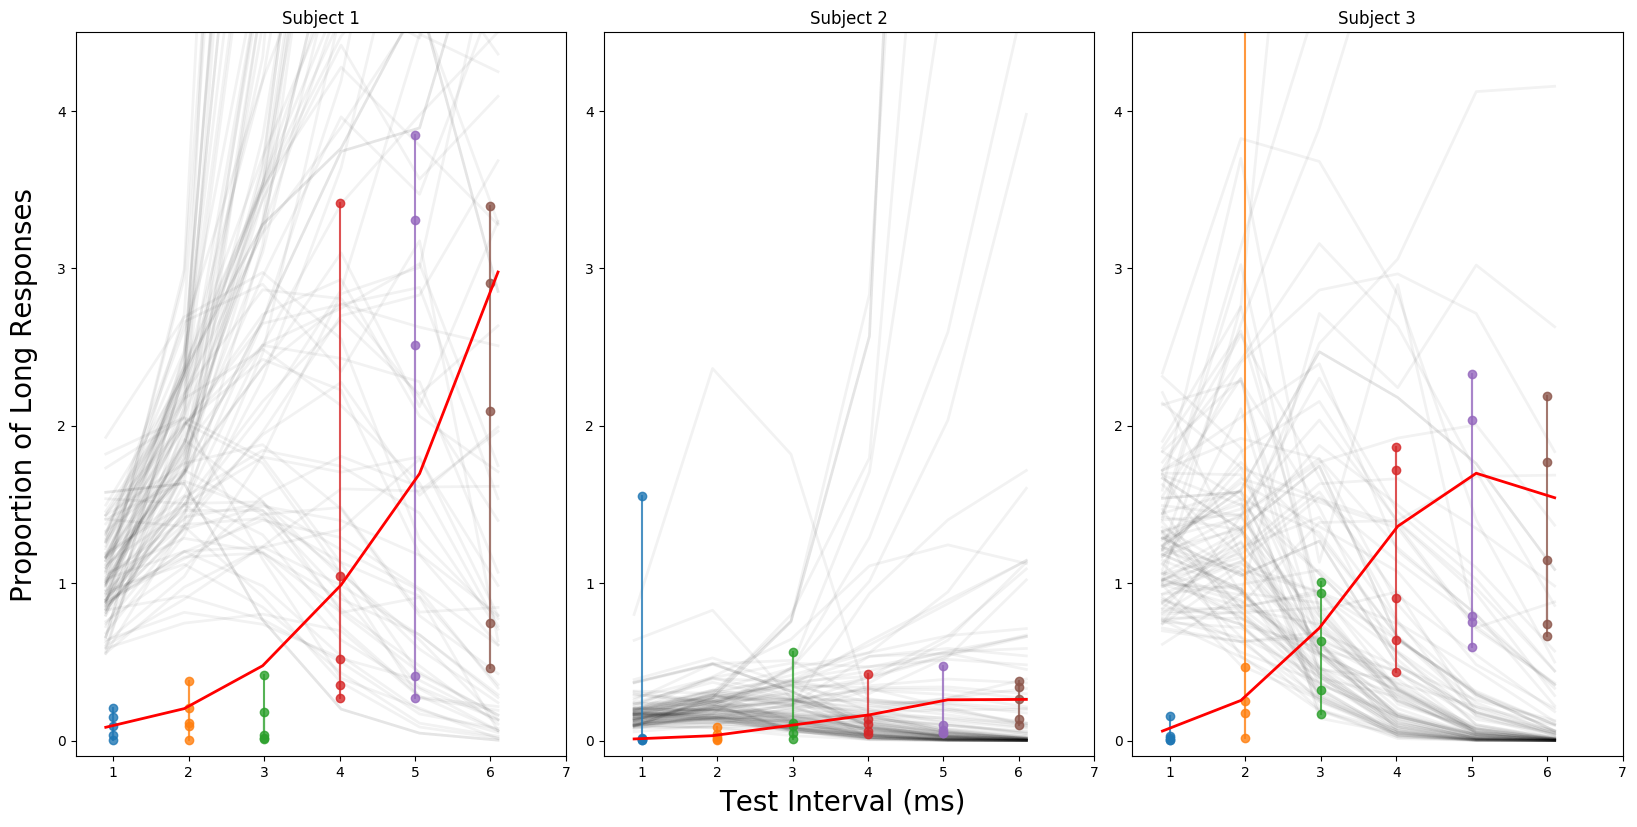

[-3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.
  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.
  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.
  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.
  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2.]
90
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2711.27it/s]


[0. 0. 0. 1. 1. 2. 5.]


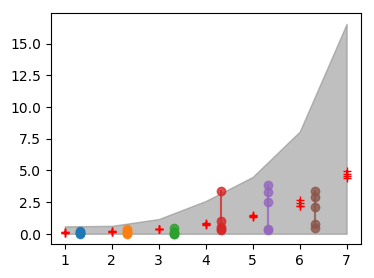

[0. 0. 0. 0. 0. 0. 0.]


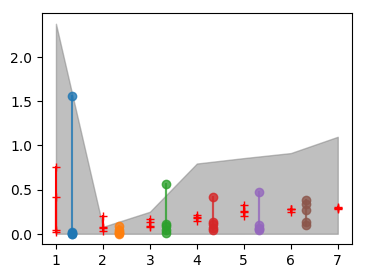

[0. 0. 0. 1. 2. 2. 1.]


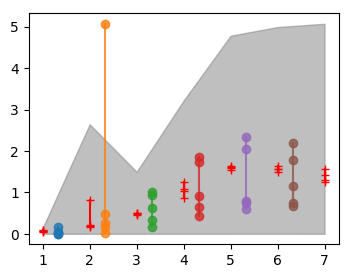

[[0. 0. 0. 1. 1. 2. 5.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 2. 2. 1.]]
1
[ 0  1  7 11 19 20]
(90, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[-2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.]


Average Loss = 81.816: 100%|████████████████████████████████████████████████████| 20000/20000 [00:29<00:00, 678.77it/s]
Finished [100%]: Average Loss = 81.813
Average Loss = 80.992: 100%|███████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1061.02it/s]
Finished [100%]: Average Loss = 80.984
Assigned BinaryGibbsMetropolis to zij
100%|█████████████████████████████████████████████████████████████████████████████▉| 3497/3500 [07:12<00:00,  8.09it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 313 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|███████████████

WAIC_r(WAIC=50.855333019101096, WAIC_se=30.30079510164338, p_WAIC=20.261809931770866)
50.855333019101096
LOO_r(LOO=52.879781142664754, LOO_se=30.322667745306468, p_LOO=21.2740339935527)


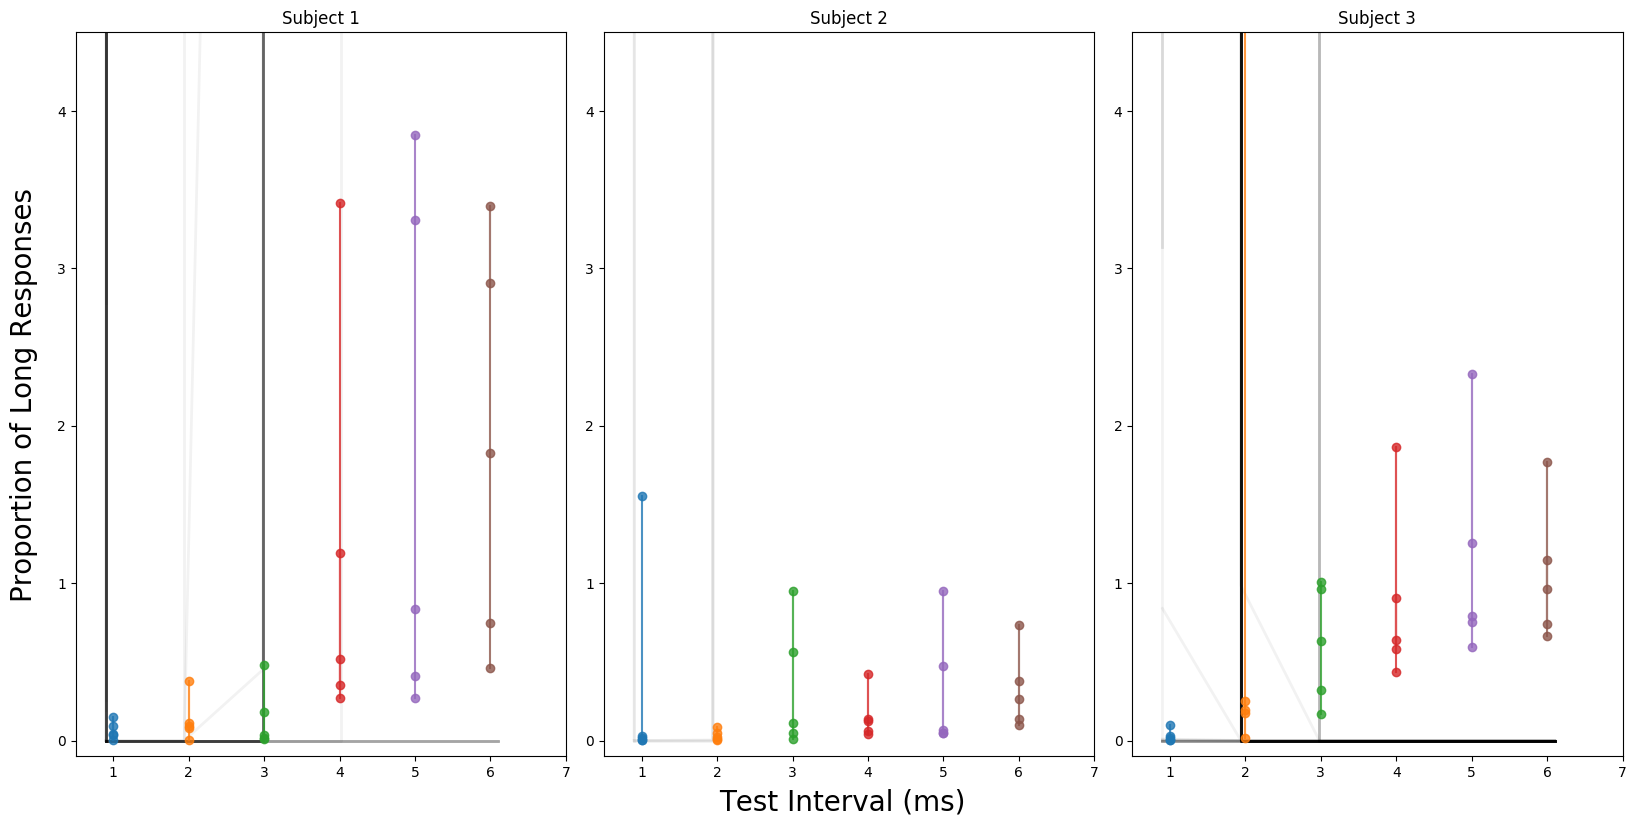

[-3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.
  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.
  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.
  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.
  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2.]
90
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2996.52it/s]


[1. 1. 1. 1. 1. 1. 1.]


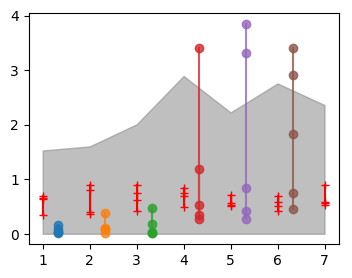

[1. 1. 1. 0. 0. 0. 1.]


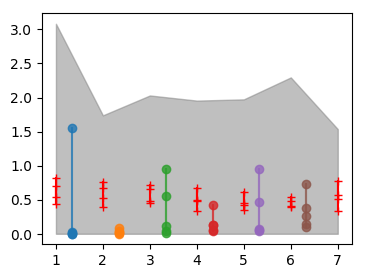

[1. 1. 1. 1. 1. 1. 1.]


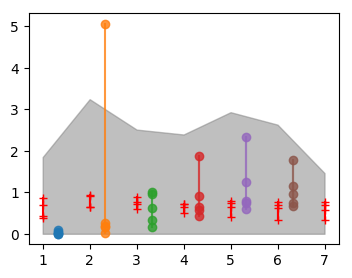

[[1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1.]]
2
[ 0  5 10 11 14 20]
(90, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[-2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.]


Average Loss = 81.282: 100%|████████████████████████████████████████████████████| 20000/20000 [00:26<00:00, 767.72it/s]
Finished [100%]: Average Loss = 81.344
Average Loss = 79.692: 100%|███████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1179.55it/s]
Finished [100%]: Average Loss = 79.744
Assigned BinaryGibbsMetropolis to zij
100%|█████████████████████████████████████████████████████████████████████████████▉| 3499/3500 [02:34<00:00, 22.61it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.3696223020705126, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 1361 diverging samples after tuning. If increasing `target_accept` does not help try to r

WAIC_r(WAIC=-19.31954098110834, WAIC_se=32.05418372142315, p_WAIC=17.275000263664964)
-19.31954098110834
LOO_r(LOO=-14.65713971998672, LOO_se=32.607005255027204, p_LOO=19.606200894225772)


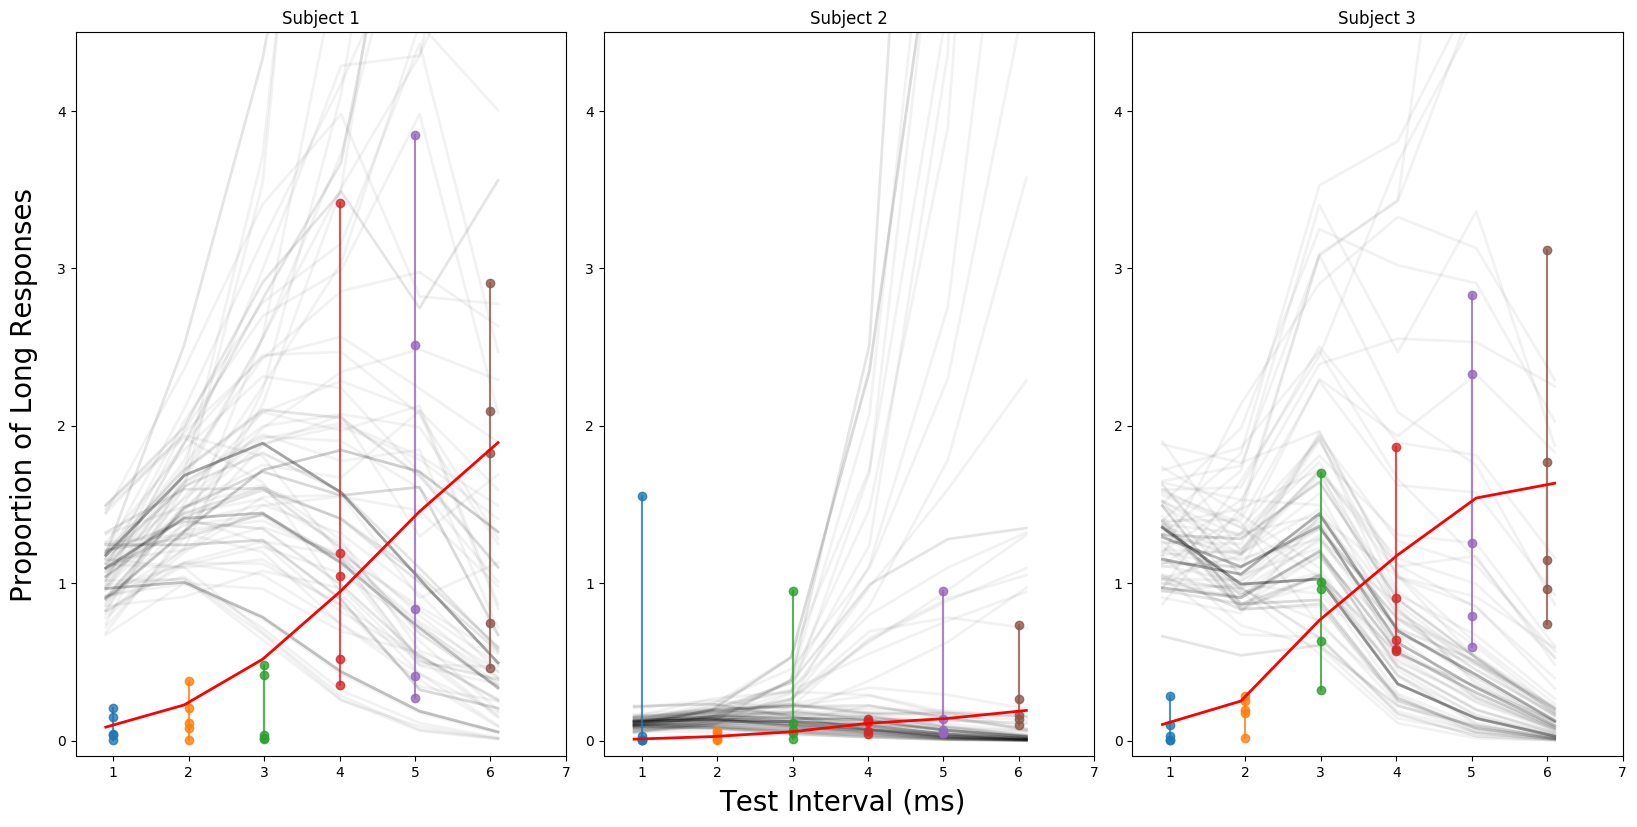

[-3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.
  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.
  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.
  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.
  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2.]
90
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2944.98it/s]


[0. 0. 0. 1. 1. 2. 2.]


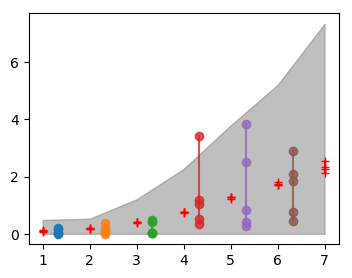

[0. 0. 0. 0. 0. 0. 0.]


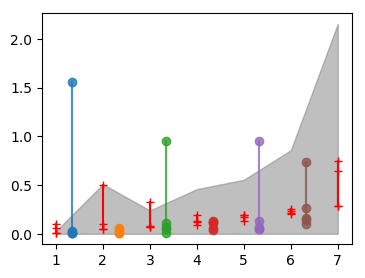

[0. 0. 1. 1. 1. 2. 2.]


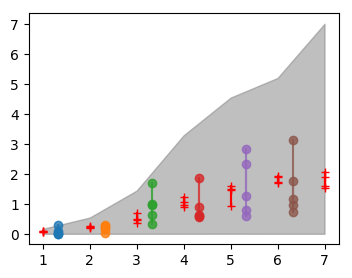

[[0. 0. 0. 1. 1. 2. 2.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 2. 2.]]
3
[ 3  6  7  8 14 17]
(90, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[-2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.]


Average Loss = 79.464: 100%|████████████████████████████████████████████████████| 20000/20000 [00:26<00:00, 767.28it/s]
Finished [100%]: Average Loss = 79.415
Average Loss = 77.914: 100%|███████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1170.76it/s]
Finished [100%]: Average Loss = 77.917
Assigned BinaryGibbsMetropolis to zij
100%|█████████████████████████████████████████████████████████████████████████████▉| 3499/3500 [03:15<00:00, 17.90it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.6901135509278229, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 600 diverging samples after tuning. If increasing `target_accept` does not help try to re

WAIC_r(WAIC=-6.937250117761666, WAIC_se=31.045999243631265, p_WAIC=9.785503825651428)
-6.937250117761666
LOO_r(LOO=-3.583745049068715, LOO_se=31.291226823342857, p_LOO=11.462256359997907)


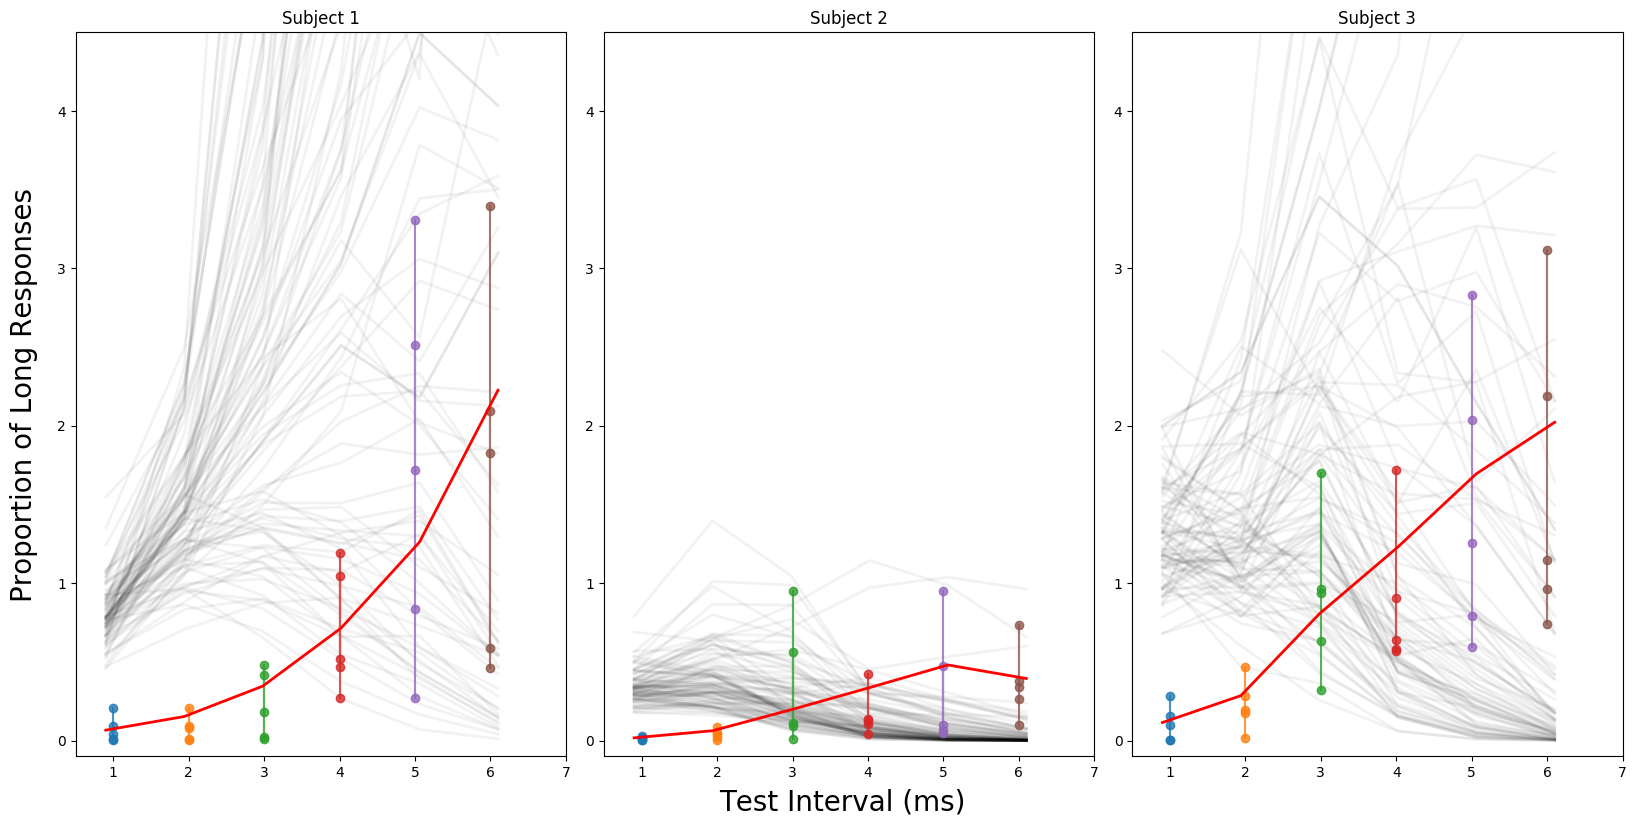

[-3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.
  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.
  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.
  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.
  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2.]
90
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2927.52it/s]


[0. 0. 0. 1. 1. 2. 3.]


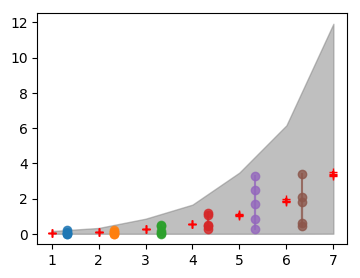

[0. 0. 0. 0. 0. 0. 0.]


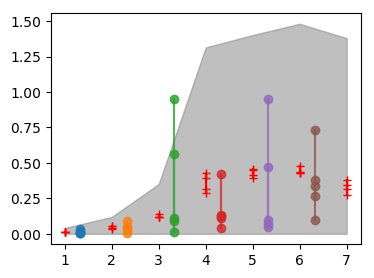

[0. 0. 1. 1. 2. 2. 2.]


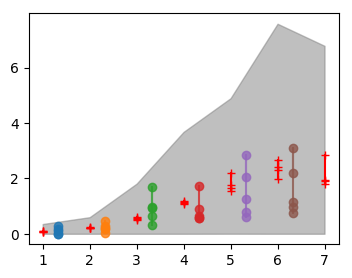

[[0. 0. 0. 1. 1. 2. 3.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 2. 2. 2.]]
4
[ 1  3  9 12 15 18]
(90, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[-2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.]


Average Loss = 86.571: 100%|████████████████████████████████████████████████████| 20000/20000 [00:26<00:00, 767.94it/s]
Finished [100%]: Average Loss = 86.481
Average Loss = 85.411: 100%|███████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1147.82it/s]
Finished [100%]: Average Loss = 85.436
Assigned BinaryGibbsMetropolis to zij
100%|█████████████████████████████████████████████████████████████████████████████▉| 3499/3500 [02:53<00:00, 20.14it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 420 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [02:53<00:00, 20.15it/s]


WAIC_r(WAIC=-1.2551164993408093, WAIC_se=37.130375848197104, p_WAIC=16.276243137013893)
-1.2551164993408093
LOO_r(LOO=5.055611108809176, LOO_se=38.77222280055545, p_LOO=19.43160694108888)


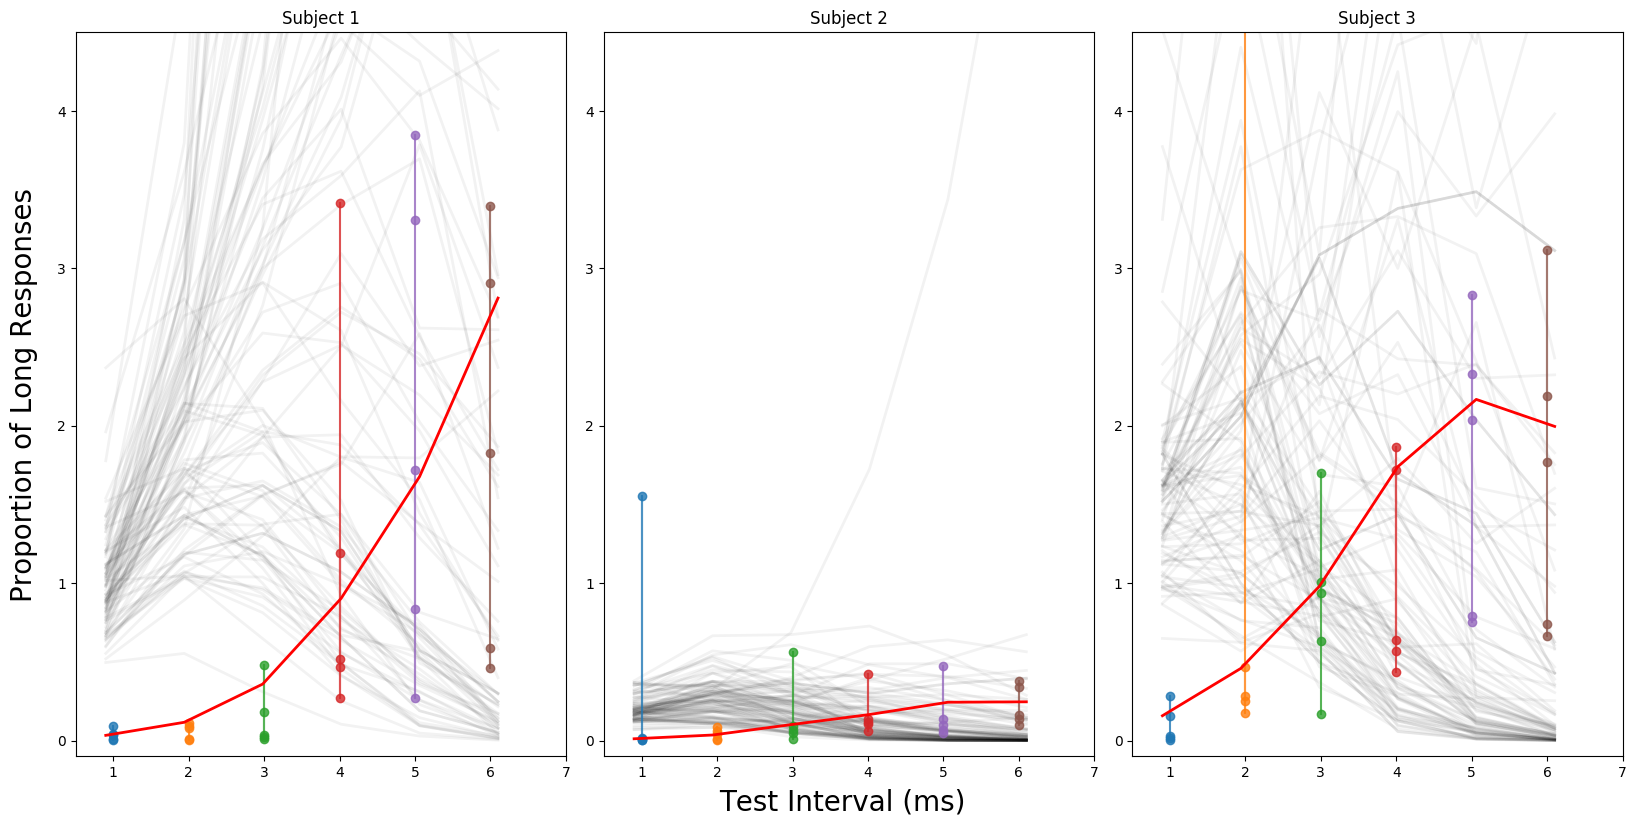

[-3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.
  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.
  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.
  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.
  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2.]
90
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2940.99it/s]


[0. 0. 0. 1. 1. 2. 4.]


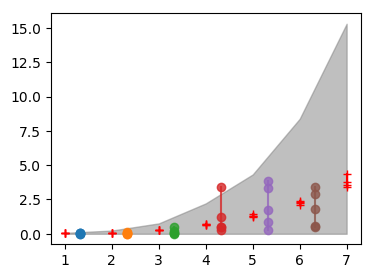

[0. 0. 0. 0. 0. 0. 0.]


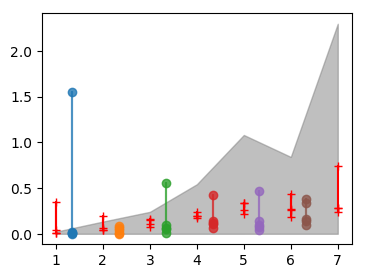

[0. 0. 1. 1. 2. 2. 2.]


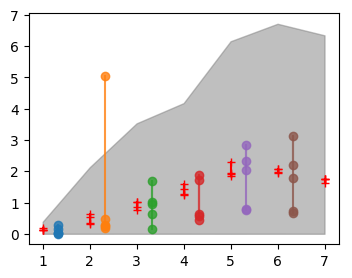

[[0. 0. 0. 1. 1. 2. 4.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 2. 2. 2.]]
5
[ 4  6  7 10 18 19]
(90, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[-2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.]


Average Loss = 74.804: 100%|████████████████████████████████████████████████████| 20000/20000 [00:26<00:00, 759.24it/s]
Finished [100%]: Average Loss = 74.794
Average Loss = 73.784: 100%|███████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1160.87it/s]
Finished [100%]: Average Loss = 73.708
Assigned BinaryGibbsMetropolis to zij
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [02:47<00:00, 20.87it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.7057264239167086, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 433 diverging samples after tuning. If increasing `target_accept` does not help try to re

WAIC_r(WAIC=-28.12677139298155, WAIC_se=34.14970194586903, p_WAIC=16.632938019968456)
-28.12677139298155
LOO_r(LOO=-24.168686780296536, LOO_se=34.7078496947505, p_LOO=18.611980326310963)


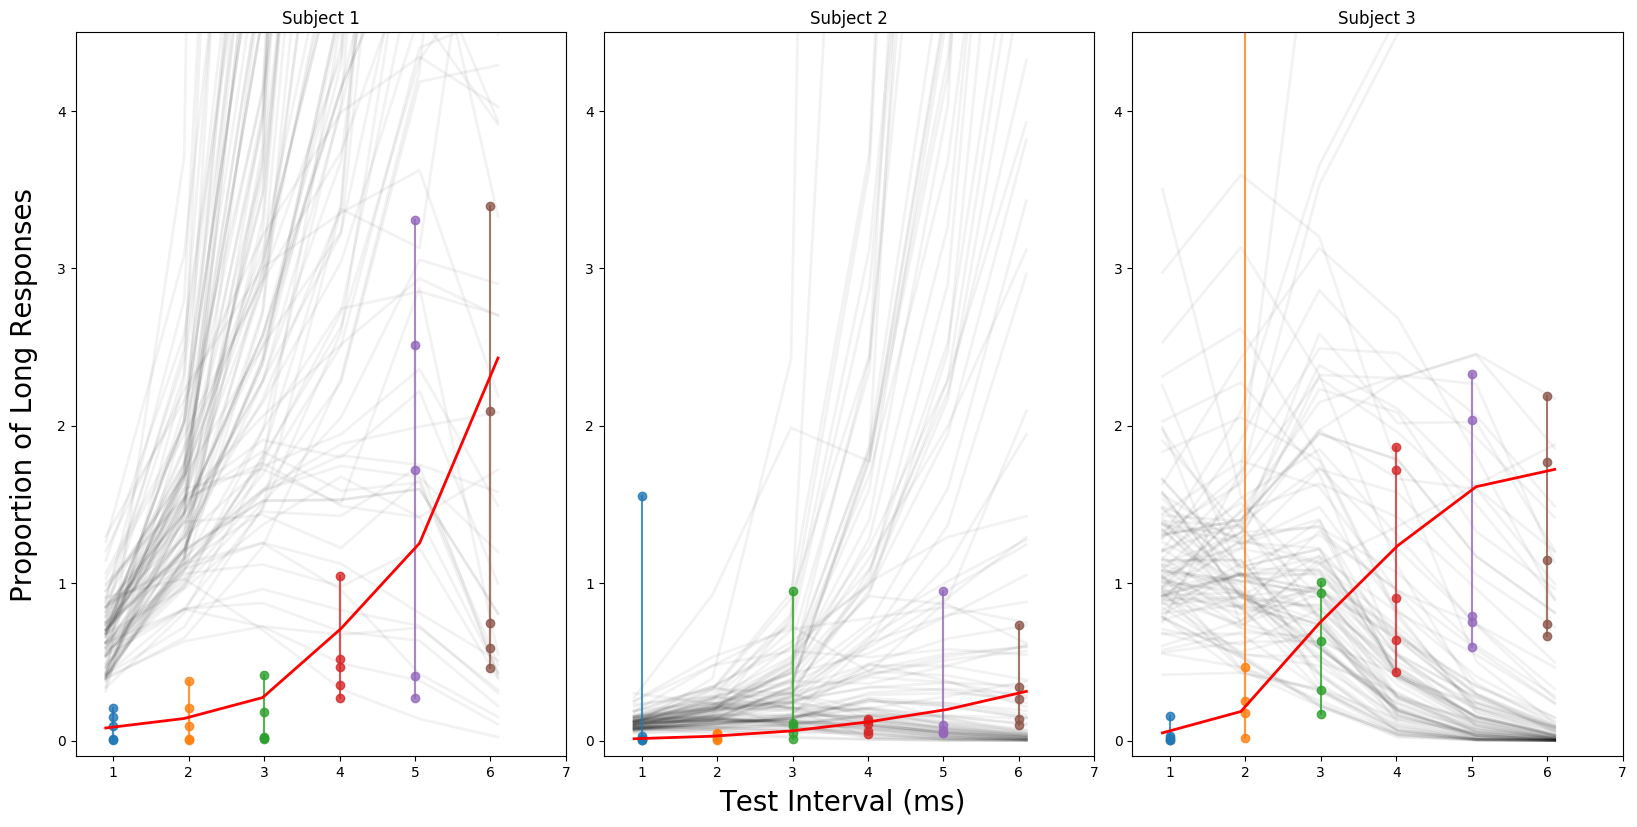

[-3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.
  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.
  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.
  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.
  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2.]
90
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2942.02it/s]


[0. 0. 0. 0. 1. 2. 6.]


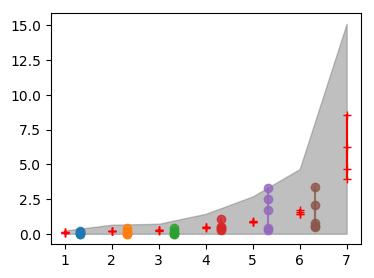

[0. 0. 0. 0. 0. 0. 1.]


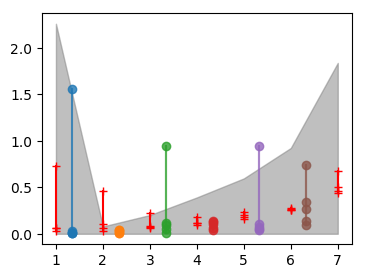

[0. 0. 1. 1. 1. 2. 2.]


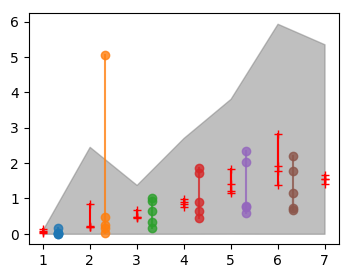

[[0. 0. 0. 0. 1. 2. 6.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 1. 2. 2.]]
6
[ 0  1  9 10 16 18]
(90, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[-2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.]


Average Loss = 89.463: 100%|████████████████████████████████████████████████████| 20000/20000 [00:26<00:00, 758.08it/s]
Finished [100%]: Average Loss = 89.453
Average Loss = 88.678: 100%|███████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1157.97it/s]
Finished [100%]: Average Loss = 88.639
Assigned BinaryGibbsMetropolis to zij
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [04:34<00:00, 12.75it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.8934558195284378, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 63 diverging samples after tuning. If increasing `target_accept` does not help try to rep

WAIC_r(WAIC=55.52038181226556, WAIC_se=32.20645660314664, p_WAIC=19.07152461408314)
55.52038181226556
LOO_r(LOO=57.23646904228043, LOO_se=32.565246776139695, p_LOO=19.929568229090574)


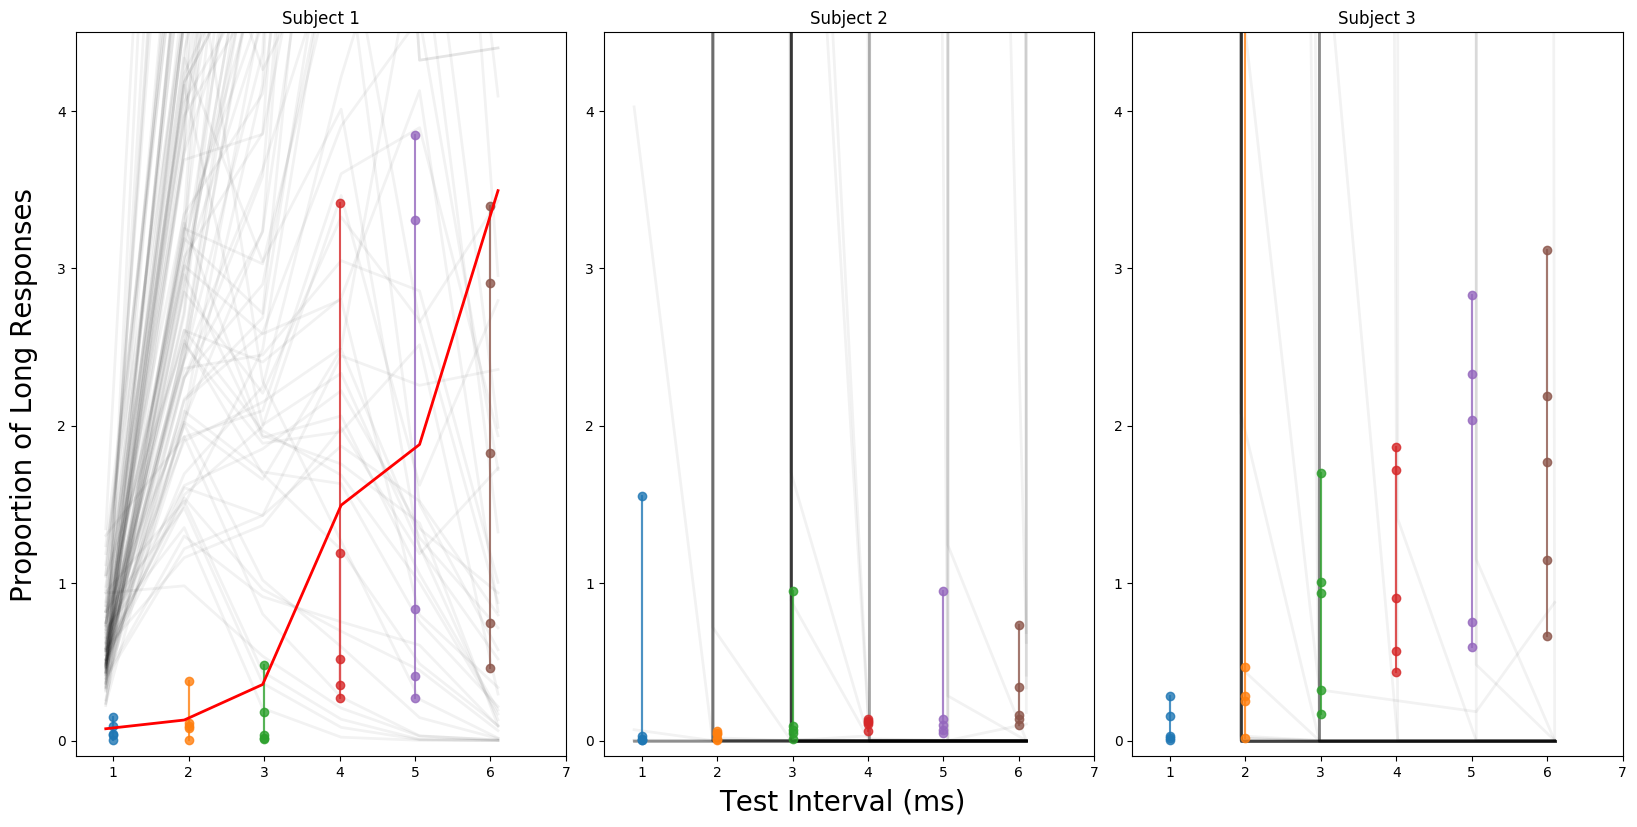

[-3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.
  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.
  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.
  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.
  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2.]
90
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2752.32it/s]


[ 0.  0.  1.  1.  2.  5. 92.]


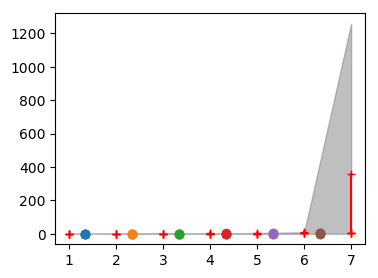

[4.e-01 5.e-01 5.e+09 3.e+13 2.e+13 7.e+08 6.e-01]


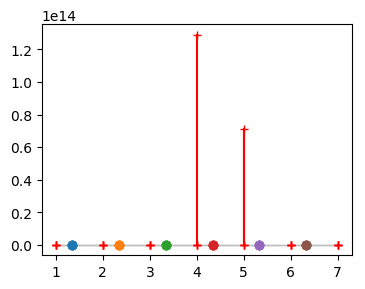

[1. 1. 1. 1. 1. 1. 1.]


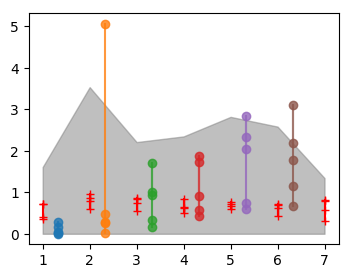

[[9.e-02 2.e-01 8.e-01 1.e+00 2.e+00 5.e+00 9.e+01]
 [4.e-01 5.e-01 5.e+09 3.e+13 2.e+13 7.e+08 6.e-01]
 [5.e-01 8.e-01 7.e-01 7.e-01 7.e-01 6.e-01 6.e-01]]
7
[ 1  6  8 13 15 20]
(90, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[-2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.]


Average Loss = 81.143: 100%|████████████████████████████████████████████████████| 20000/20000 [00:28<00:00, 693.45it/s]
Finished [100%]: Average Loss = 81.078
Average Loss = 79.561: 100%|███████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1075.95it/s]
Finished [100%]: Average Loss = 79.535
Assigned BinaryGibbsMetropolis to zij
100%|█████████████████████████████████████████████████████████████████████████████▉| 3498/3500 [06:58<00:00,  8.36it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 346 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [06:58<00:00,  8.36it/s]


WAIC_r(WAIC=52.80053957803956, WAIC_se=28.163590812868243, p_WAIC=22.104239940685662)
52.80053957803956
LOO_r(LOO=53.43461804345309, LOO_se=28.517152757571793, p_LOO=22.421279173392428)


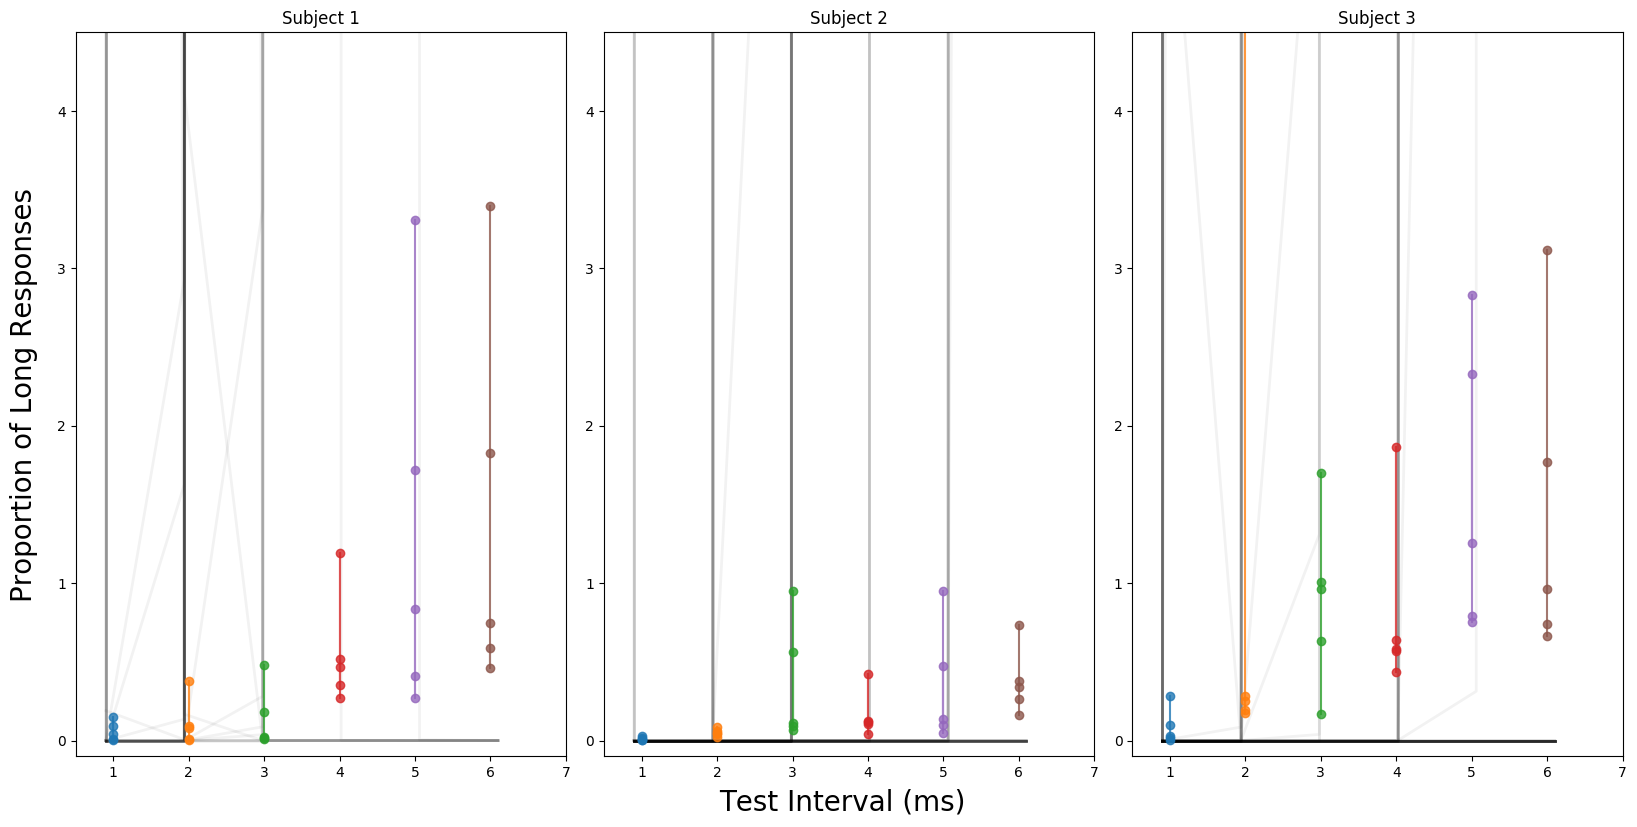

[-3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.
  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.
  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.
  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.
  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2.]
90
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2758.89it/s]


[0. 0. 1. 1. 1. 1. 1.]


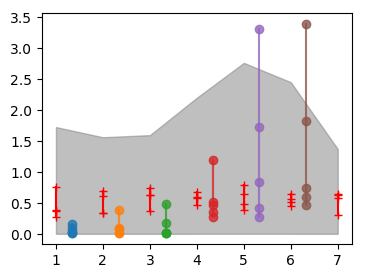

[4.e-001 5.e-001 5.e-001 5.e-001 3.e+105 5.e-001 4.e-001]


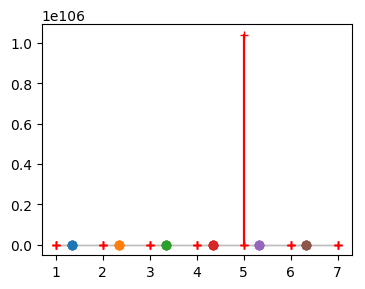

[1. 1. 1. 1. 1. 1. 1.]


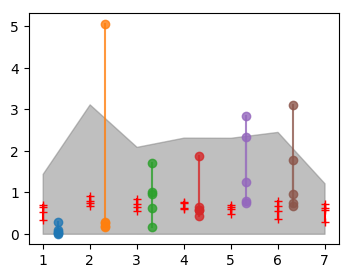

[[4.e-001 5.e-001 6.e-001 6.e-001 6.e-001 5.e-001 5.e-001]
 [4.e-001 5.e-001 5.e-001 5.e-001 3.e+105 5.e-001 4.e-001]
 [6.e-001 8.e-001 7.e-001 7.e-001 6.e-001 6.e-001 5.e-001]]
8
[ 3  5  7 11 18 19]
(90, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[-2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.]


Average Loss = 85.911: 100%|████████████████████████████████████████████████████| 20000/20000 [00:28<00:00, 690.66it/s]
Finished [100%]: Average Loss = 85.888
Average Loss = 84.186: 100%|███████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1091.74it/s]
Finished [100%]: Average Loss = 84.211
Assigned BinaryGibbsMetropolis to zij
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [02:46<00:00, 21.00it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.4943150333878612, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 1145 diverging samples after tuning. If increasing `target_accept` does not help try to r

WAIC_r(WAIC=1.650199440373787, WAIC_se=35.56758391480696, p_WAIC=18.772941442913158)
1.650199440373787
LOO_r(LOO=10.859549327371404, LOO_se=36.88798402950162, p_LOO=23.37761638641196)


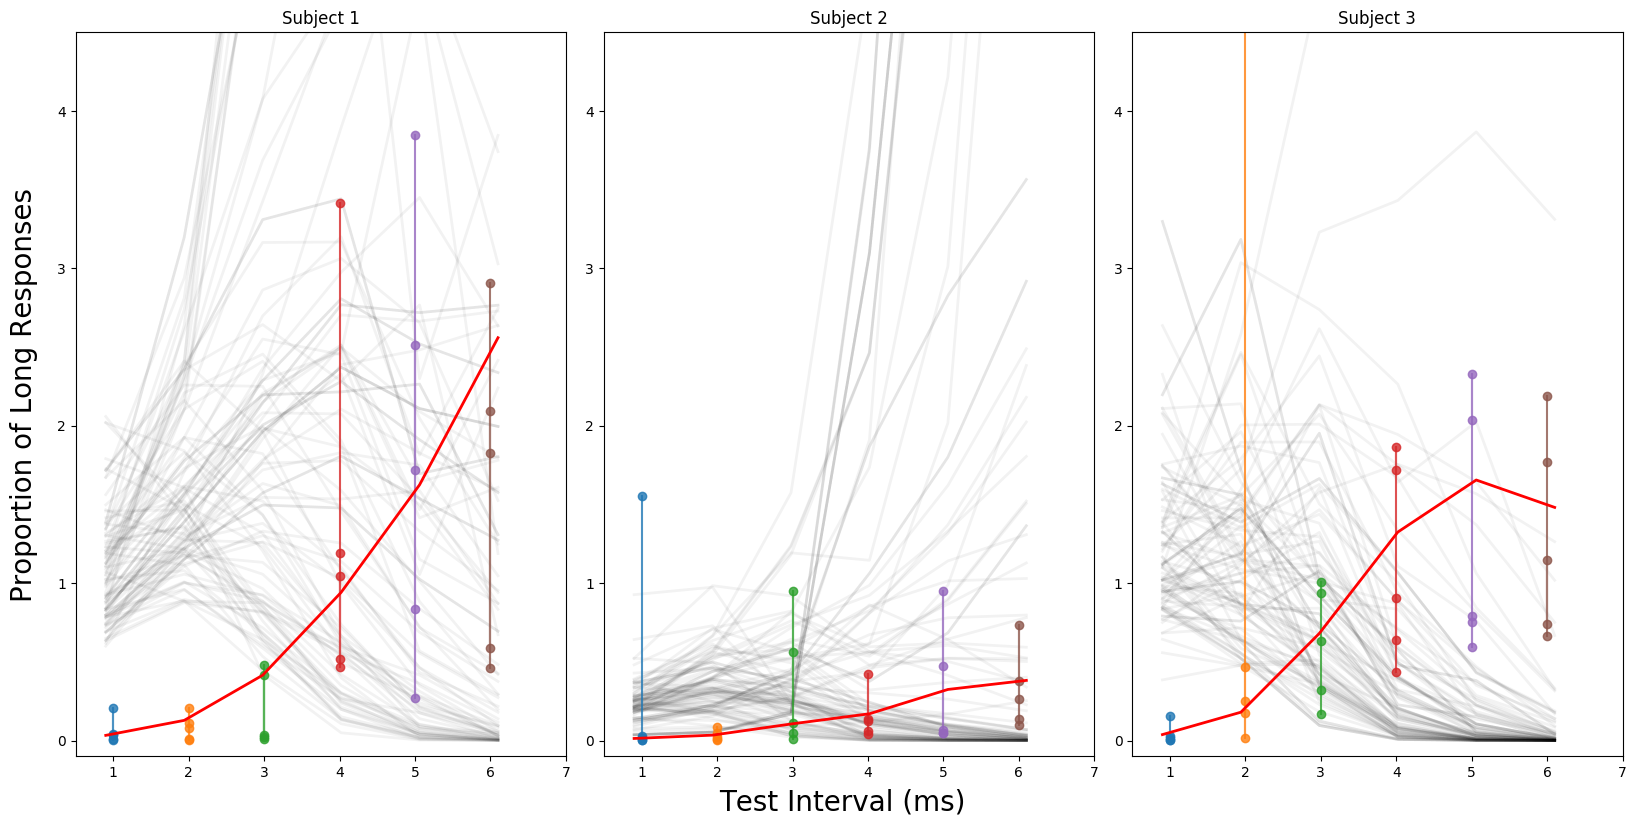

[-3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.
  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.
  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.
  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.
  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2.]
90
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2718.71it/s]


[0. 0. 0. 1. 1. 2. 2.]


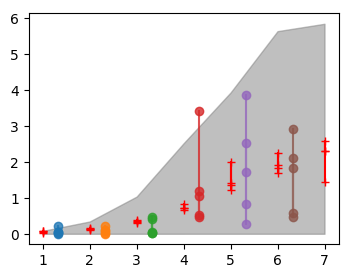

[0. 0. 0. 0. 0. 0. 1.]


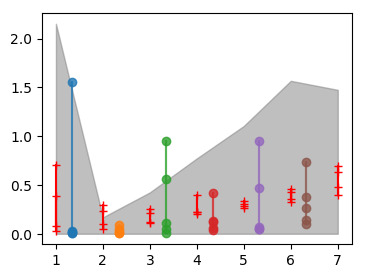

[0. 0. 0. 1. 2. 2. 2.]


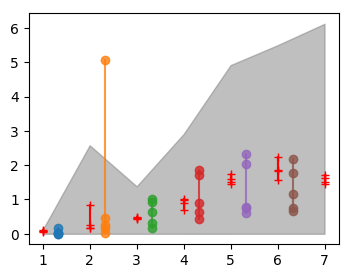

[[0. 0. 0. 1. 1. 2. 2.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 2. 2. 2.]]
9
[ 0  3  9 12 15 17]
(90, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[-2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.]


Average Loss = 94.021: 100%|████████████████████████████████████████████████████| 20000/20000 [00:29<00:00, 680.53it/s]
Finished [100%]: Average Loss = 94.043
Average Loss = 92.377: 100%|████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 985.01it/s]
Finished [100%]: Average Loss = 92.371
Assigned BinaryGibbsMetropolis to zij
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [07:41<00:00,  7.59it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 230 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



WAIC_r(WAIC=79.24431278488758, WAIC_se=31.38395976824101, p_WAIC=18.429425462316438)
79.24431278488758
LOO_r(LOO=81.57420278295508, LOO_se=31.497098880568586, p_LOO=19.594370461350188)


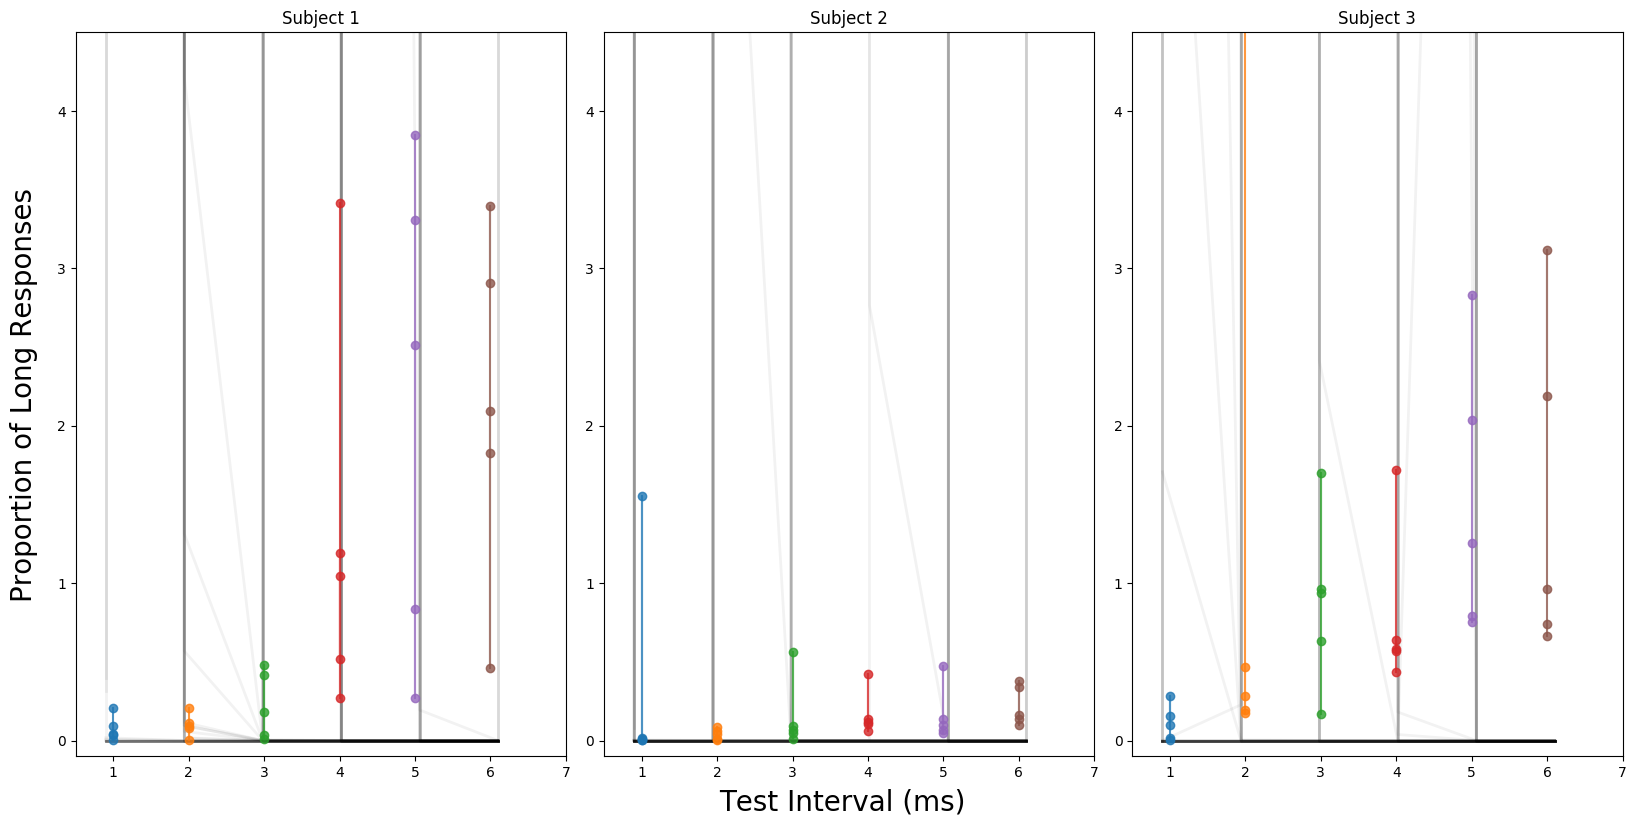

[-3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.
  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.
  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.
  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.
  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2.]
90
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2756.35it/s]


[1. 1. 1. 1. 1. 1. 1.]


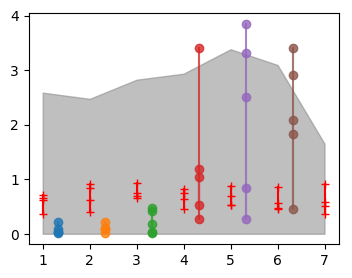

[0. 1. 1. 1. 0. 0. 1.]


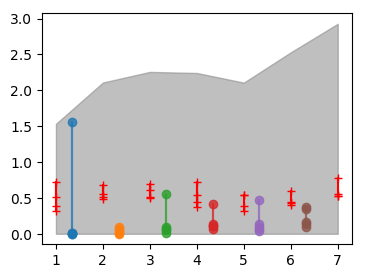

[1. 1. 1. 1. 1. 1. 1.]


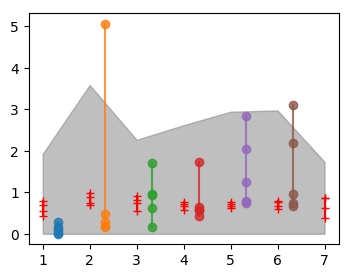

[[1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1.]]
10
[ 2  4 10 13 15 17]
(90, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[-2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.]


Average Loss = 97.589: 100%|████████████████████████████████████████████████████| 20000/20000 [00:30<00:00, 650.58it/s]
Finished [100%]: Average Loss = 97.627
Average Loss = 97.659: 100%|████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 997.25it/s]
Finished [100%]: Average Loss = 97.679
Assigned BinaryGibbsMetropolis to zij
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [03:04<00:00, 18.92it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.5733694125648258, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 918 diverging samples after tuning. If increasing `target_accept` does not help try to re

WAIC_r(WAIC=19.620341572728208, WAIC_se=35.20971751379991, p_WAIC=17.777269822969583)
19.620341572728208
LOO_r(LOO=25.845039563026567, LOO_se=36.84379607424829, p_LOO=20.88961881811876)


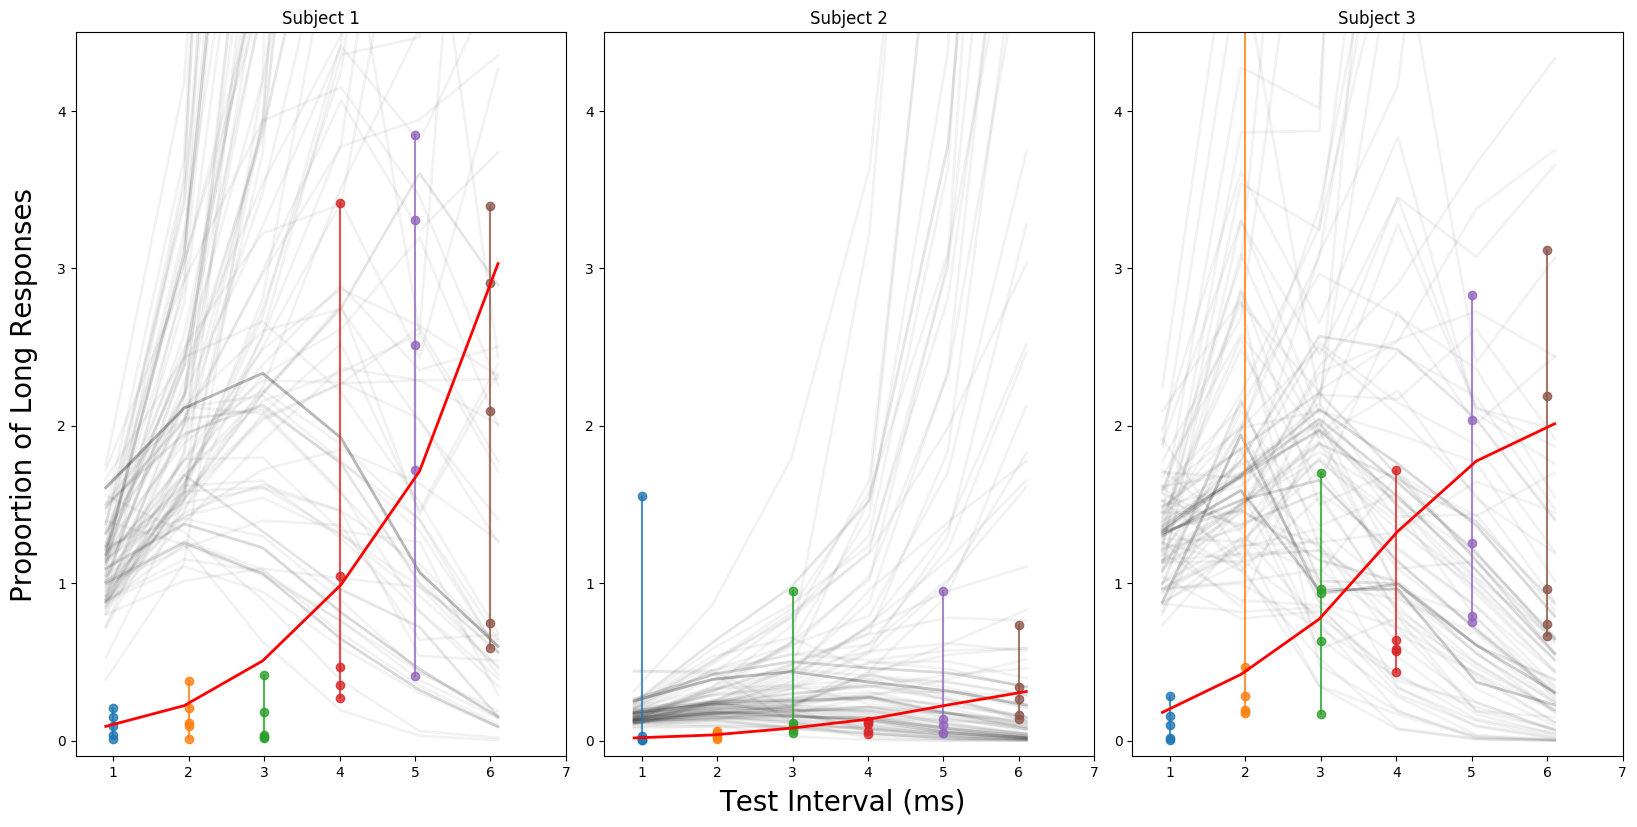

[-3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.
  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.
  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.
  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.
  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2.]
90
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1177.03it/s]


[0. 0. 0. 1. 1. 2. 4.]


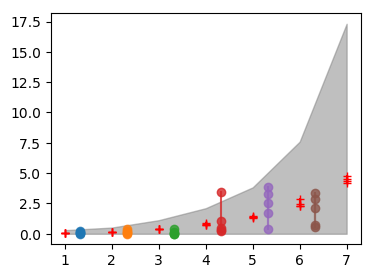

[0. 0. 0. 0. 0. 0. 0.]


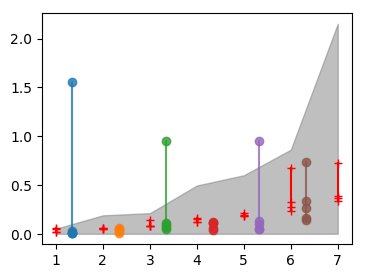

[0. 0. 1. 1. 1. 2. 2.]


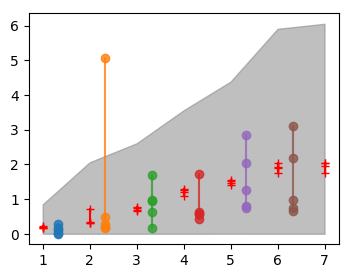

[[0. 0. 0. 1. 1. 2. 4.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 2. 2.]]
11
[ 0  6  7 13 14 19]
(90, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[-2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.]


Average Loss = 89.555: 100%|████████████████████████████████████████████████████| 20000/20000 [00:30<00:00, 659.05it/s]
Finished [100%]: Average Loss = 89.578
Average Loss = 88.189: 100%|███████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1095.79it/s]
Finished [100%]: Average Loss = 88.202
Assigned BinaryGibbsMetropolis to zij
100%|█████████████████████████████████████████████████████████████████████████████▉| 3498/3500 [02:48<00:00, 20.78it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.6861579956942666, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 665 diverging samples after tuning. If increasing `target_accept` does not help try to re

WAIC_r(WAIC=-15.287220803110188, WAIC_se=26.64183106038681, p_WAIC=14.857676614501196)
-15.287220803110188
LOO_r(LOO=-9.942376857899845, LOO_se=26.872564661635327, p_LOO=17.530098587106373)


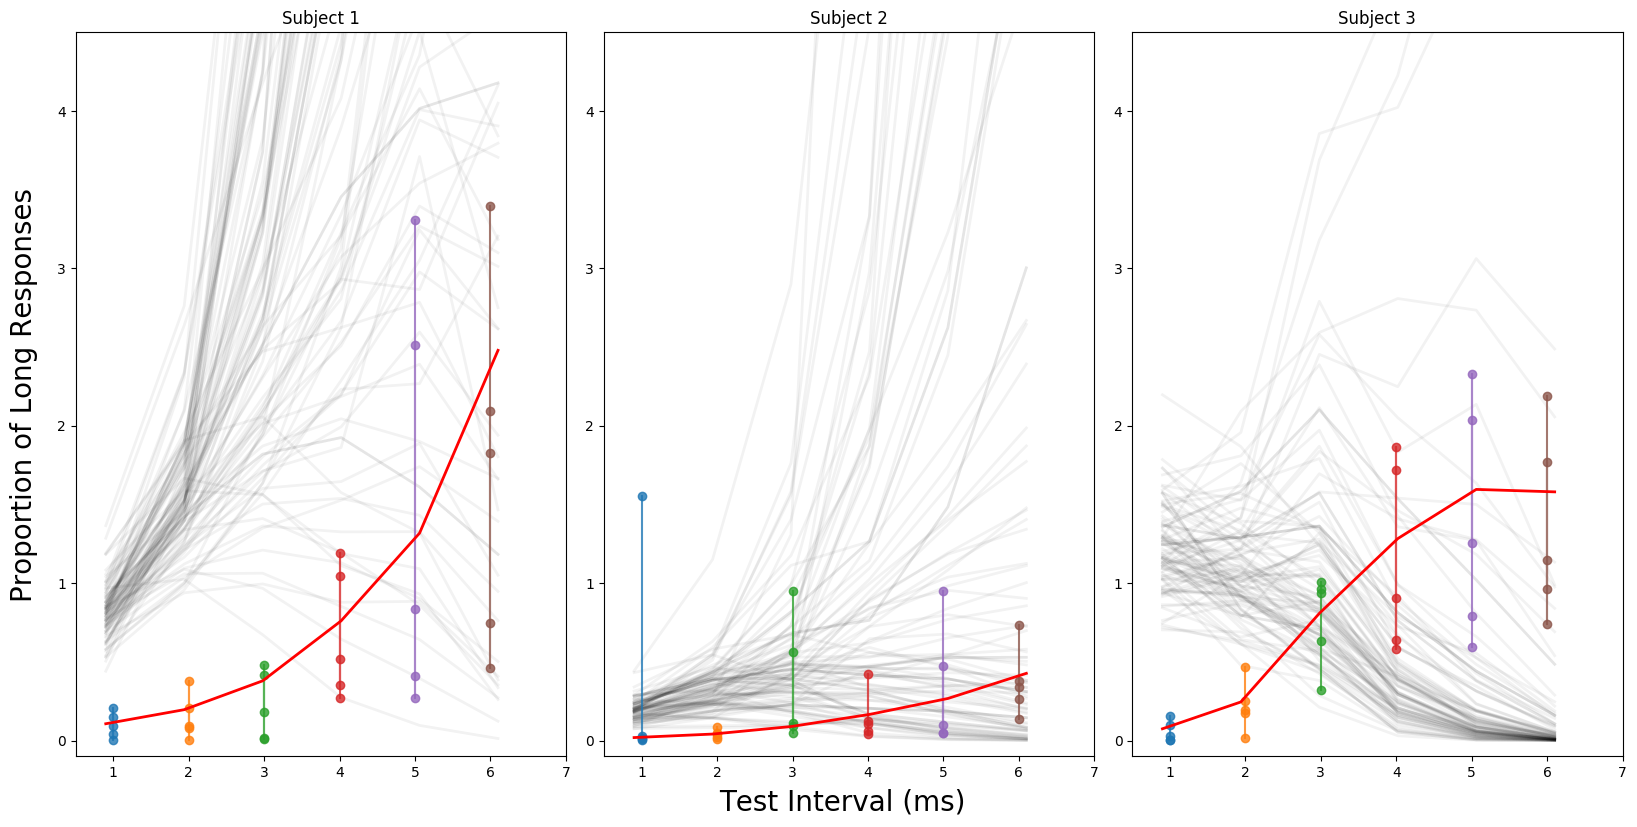

[-3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.
  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.
  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.
  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.
  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2.]
90
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2704.04it/s]


[0. 0. 0. 1. 1. 2. 3.]


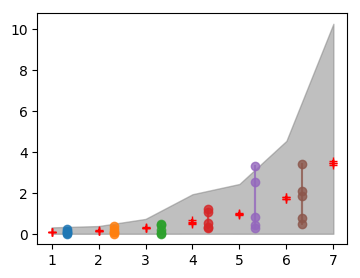

[0. 0. 0. 0. 0. 0. 0.]


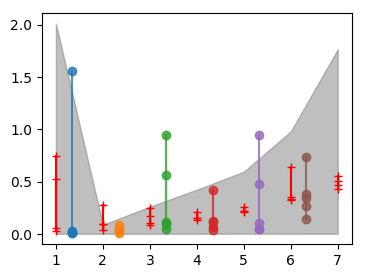

[0. 0. 0. 1. 2. 2. 1.]


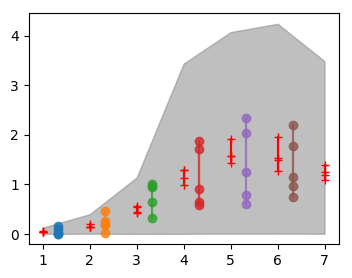

[[0. 0. 0. 1. 1. 2. 3.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 2. 2. 1.]]
12
[ 2  6  8 12 17 18]
(90, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[-2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.]


Average Loss = 78.317: 100%|████████████████████████████████████████████████████| 20000/20000 [00:30<00:00, 650.04it/s]
Finished [100%]: Average Loss = 78.309
Average Loss = 77.416: 100%|███████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1026.22it/s]
Finished [100%]: Average Loss = 77.445
Assigned BinaryGibbsMetropolis to zij
100%|█████████████████████████████████████████████████████████████████████████████▉| 3499/3500 [02:30<00:00, 23.30it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.7144645683512446, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 512 diverging samples after tuning. If increasing `target_accept` does not help try to re

WAIC_r(WAIC=-1.7802483675489365, WAIC_se=35.898810177533434, p_WAIC=16.852811780501366)
-1.7802483675489365
LOO_r(LOO=6.845292701242573, LOO_se=39.511329819373664, p_LOO=21.165582314897115)


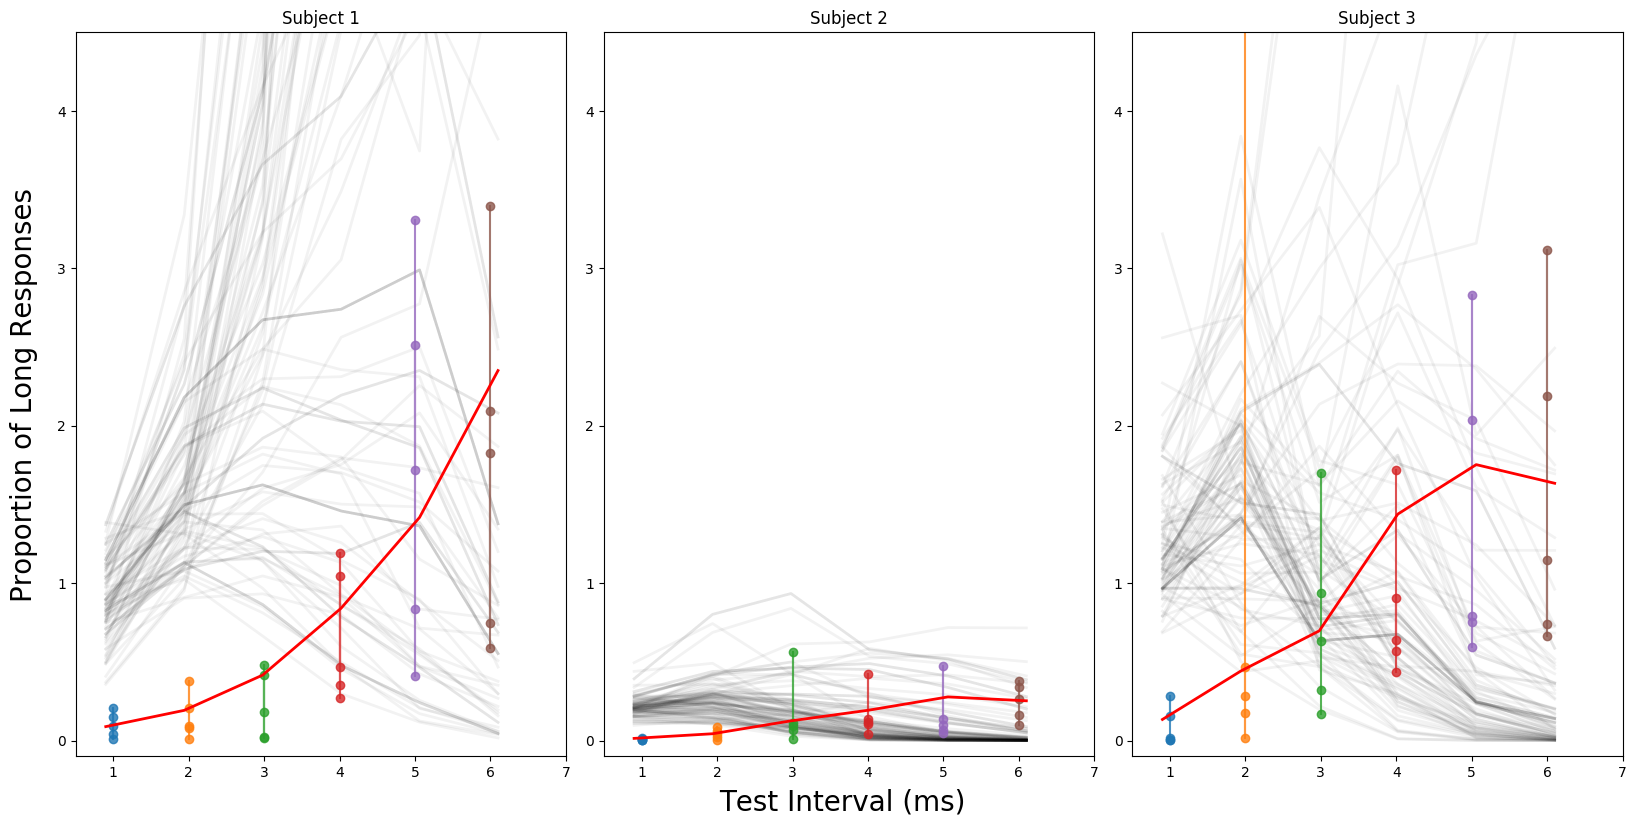

[-3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.
  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.
  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.
  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.
  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2.]
90
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2728.12it/s]


[0. 0. 0. 1. 1. 2. 5.]


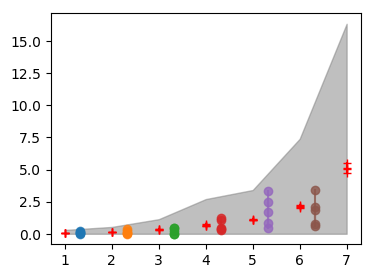

[0. 0. 0. 0. 0. 0. 0.]


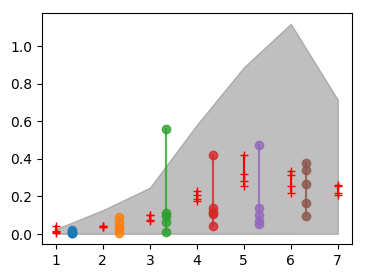

[0. 1. 1. 1. 1. 1. 2.]


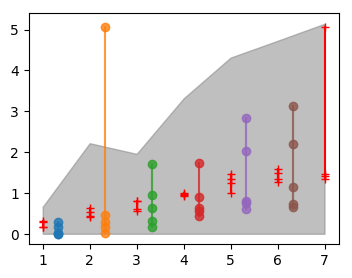

[[0. 0. 0. 1. 1. 2. 5.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 2.]]
13
[ 0  1  9 12 16 20]
(90, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[-2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.]


Average Loss = 84.404: 100%|████████████████████████████████████████████████████| 20000/20000 [00:28<00:00, 700.70it/s]
Finished [100%]: Average Loss = 84.435
Average Loss = 82.615: 100%|███████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1031.81it/s]
Finished [100%]: Average Loss = 82.561
Assigned BinaryGibbsMetropolis to zij
100%|█████████████████████████████████████████████████████████████████████████████▉| 3499/3500 [06:03<00:00,  9.62it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 222 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [06:03<00:00,  9.62it/s]


WAIC_r(WAIC=36.90482282416642, WAIC_se=34.85262210116797, p_WAIC=21.47156313666898)
36.90482282416642
LOO_r(LOO=46.52398720938923, LOO_se=34.11645725736166, p_LOO=26.28114532928038)


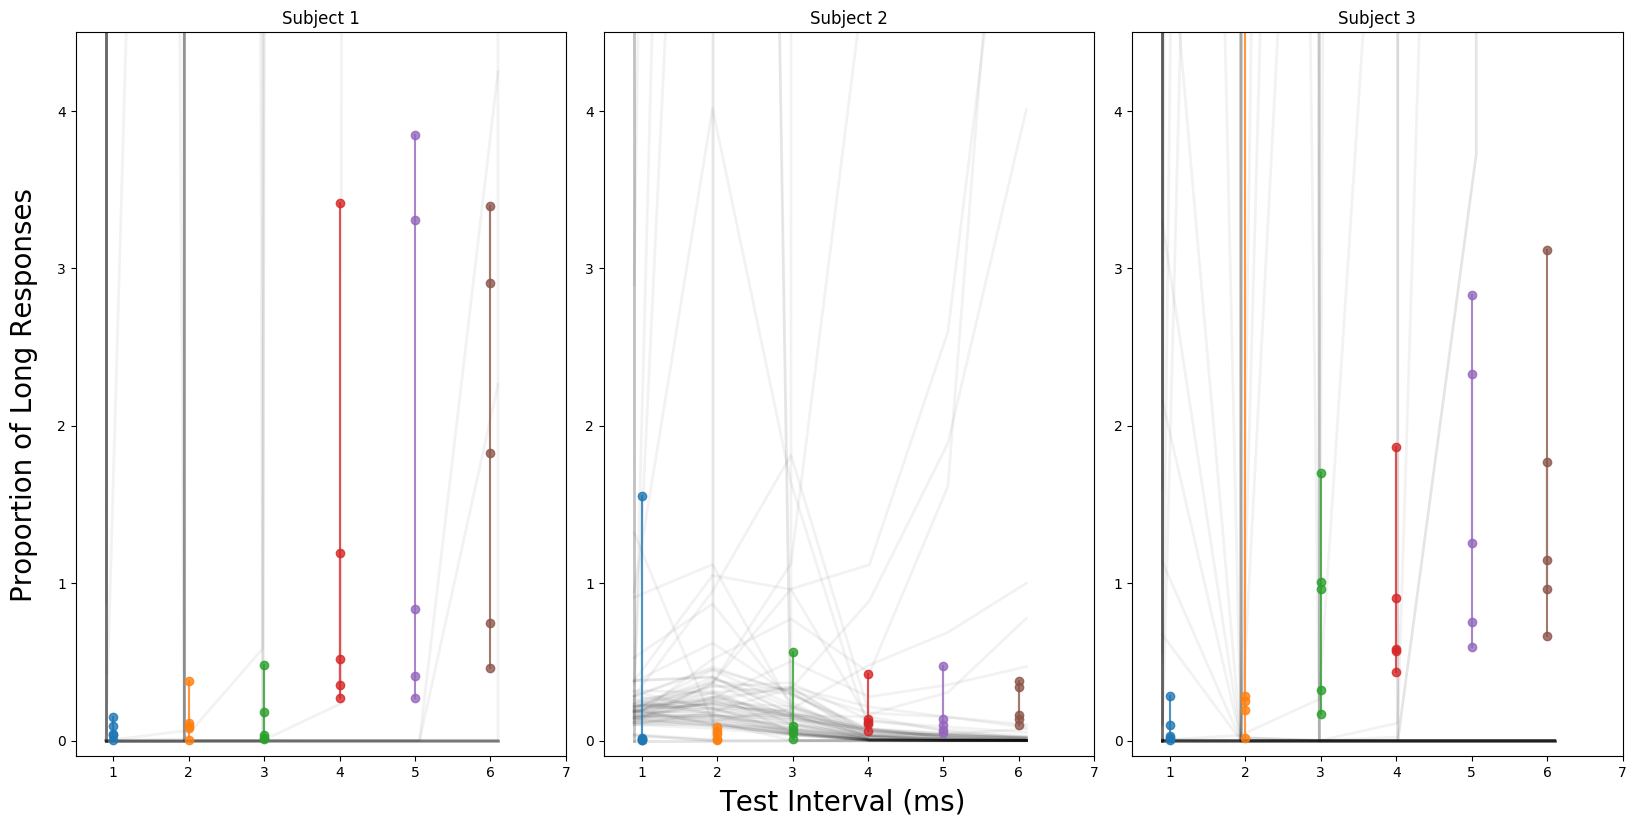

[-3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.
  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.
  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.
  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.
  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2.]
90
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2826.76it/s]


[ 1. 41.  1.  1.  1.  0.  1.]


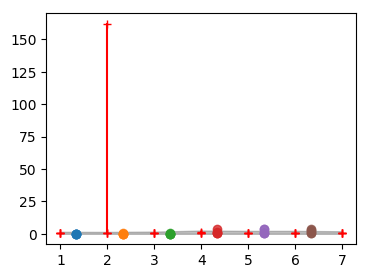

[ 0.  0.  0.  0.  0.  1. 12.]


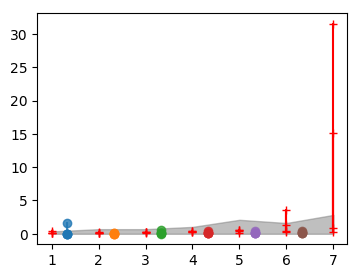

[5.e-01 8.e-01 7.e-01 7.e-01 6.e-01 5.e+03 9.e+14]


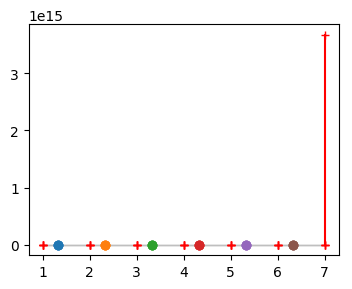

[[5.e-01 4.e+01 7.e-01 8.e-01 6.e-01 5.e-01 6.e-01]
 [2.e-01 2.e-01 3.e-01 3.e-01 4.e-01 1.e+00 1.e+01]
 [5.e-01 8.e-01 7.e-01 7.e-01 6.e-01 5.e+03 9.e+14]]
14
[ 2  6  8 13 17 19]
(90, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[-2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.]


Average Loss = 85.151: 100%|████████████████████████████████████████████████████| 20000/20000 [00:27<00:00, 727.67it/s]
Finished [100%]: Average Loss = 85.197
Average Loss = 84.183: 100%|███████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1127.58it/s]
Finished [100%]: Average Loss = 84.133
Assigned BinaryGibbsMetropolis to zij
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [12:59<00:00,  4.49it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 388 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



WAIC_r(WAIC=37.16934445920046, WAIC_se=31.969021165680612, p_WAIC=22.102964061175133)
37.16934445920046
LOO_r(LOO=42.158996056296346, LOO_se=32.49622822268979, p_LOO=24.597789859723072)


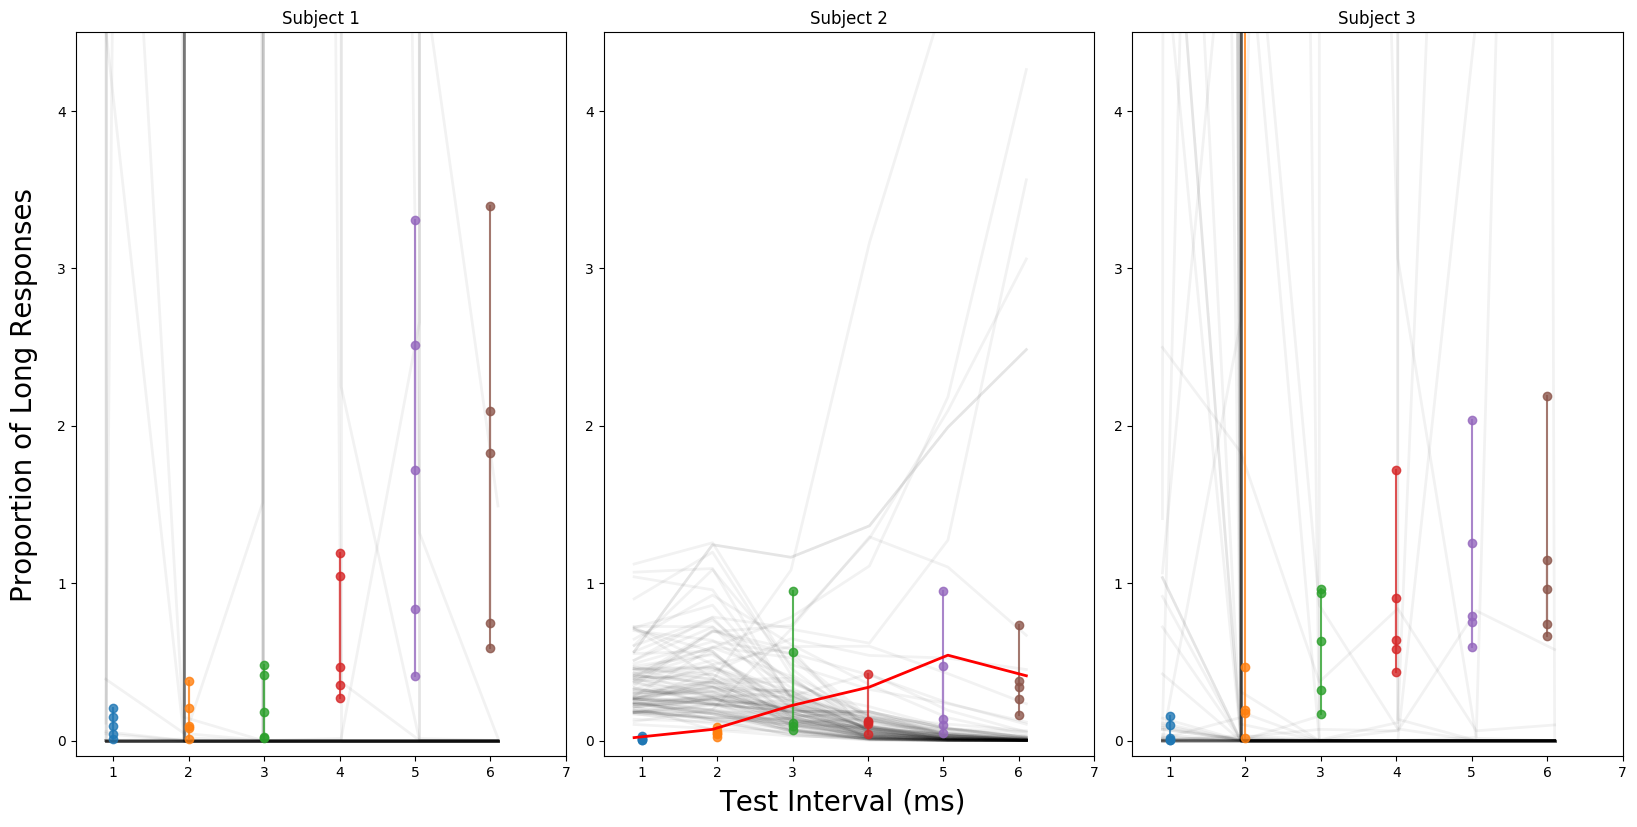

[-3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.
  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.
  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.
  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.
  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2.]
90
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2725.93it/s]


[0. 1. 1. 1. 1. 0. 6.]


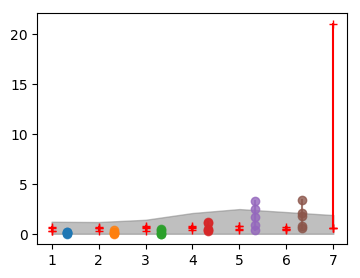

[0. 0. 0. 0. 1. 0. 0.]


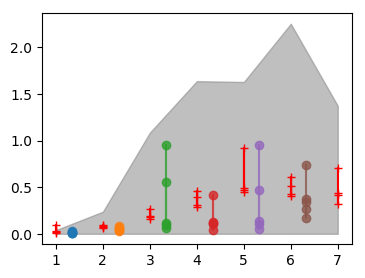

[5.e-01 7.e-01 6.e-01 6.e-01 6.e-01 1.e+12 4.e+09]


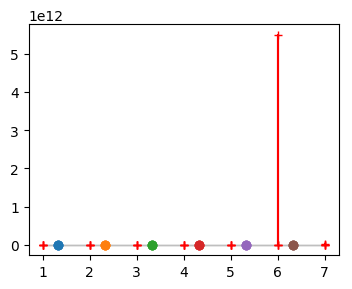

[[5.e-01 5.e-01 6.e-01 6.e-01 6.e-01 5.e-01 6.e+00]
 [4.e-02 8.e-02 2.e-01 4.e-01 6.e-01 5.e-01 5.e-01]
 [5.e-01 7.e-01 6.e-01 6.e-01 6.e-01 1.e+12 4.e+09]]
15
[ 0  1 12 13 17 20]
(90, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[-2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.]


Average Loss = 79.996: 100%|████████████████████████████████████████████████████| 20000/20000 [00:31<00:00, 637.54it/s]
Finished [100%]: Average Loss = 79.996
Average Loss = 79.698: 100%|████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 973.01it/s]
Finished [100%]: Average Loss = 79.667
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Assigned BinaryGibbsMetropolis to zij
100%|█████████████████████████████████████████████████████████████████████████████▉| 3499/3500 [02:49<00:00, 20.70it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.5812179474149008, but should be close to 0.8. Try to i

WAIC_r(WAIC=-12.627420022740582, WAIC_se=34.94544377511875, p_WAIC=16.363282085754783)
-12.627420022740582


D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\stats.py:285: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO_r(LOO=-4.950203469239366, LOO_se=35.71637570001277, p_LOO=20.201890362505388)


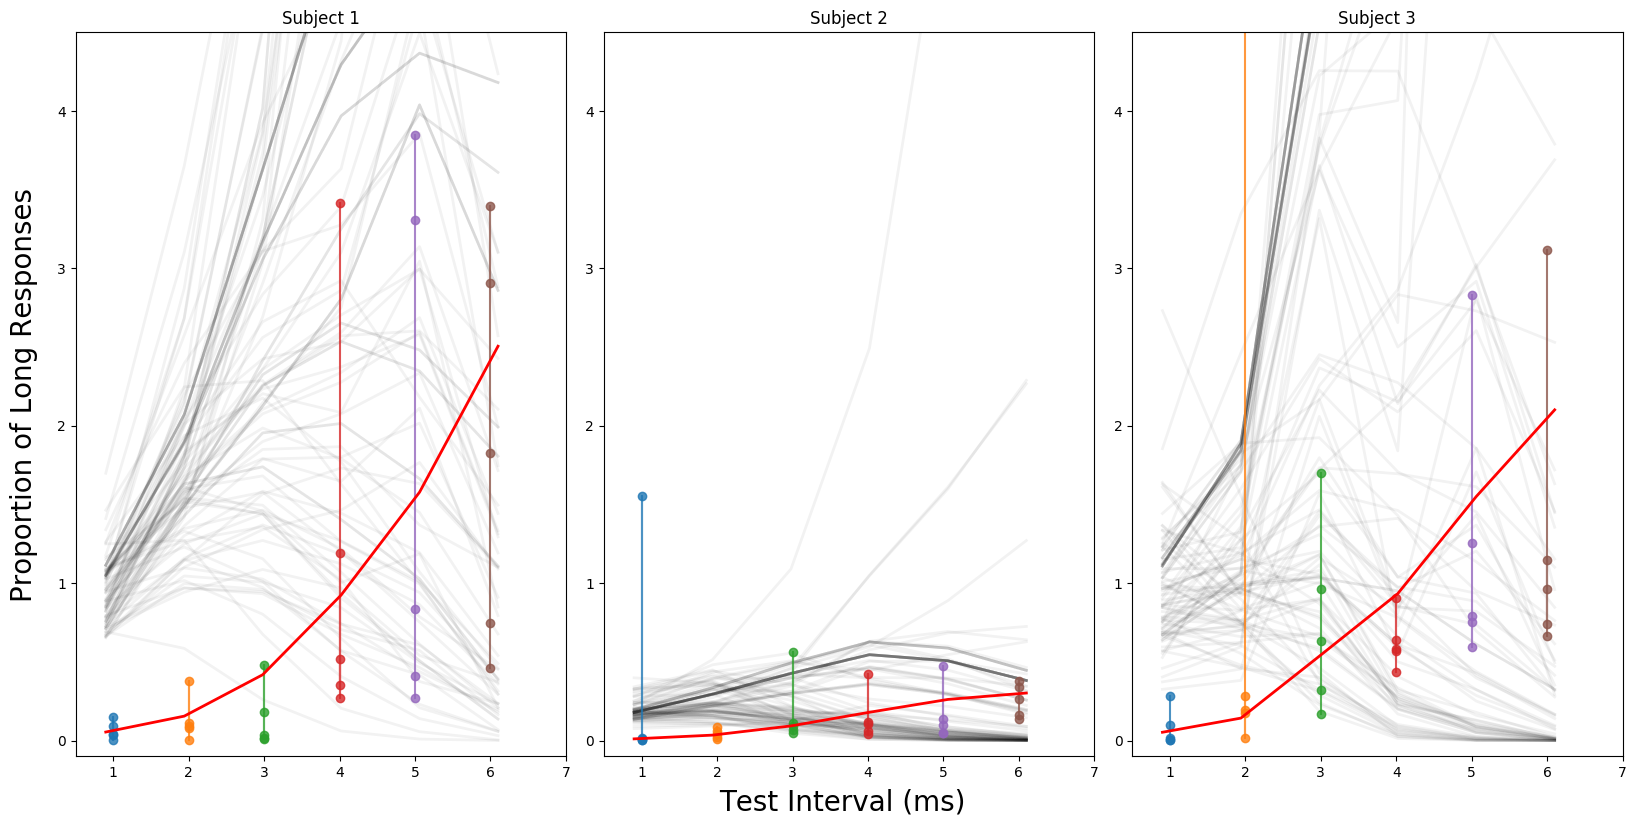

[-3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.
  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.
  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.
  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.
  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2.]
90
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2695.26it/s]


[0. 0. 0. 1. 1. 2. 4.]


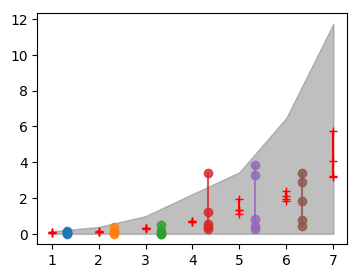

[0. 0. 0. 0. 0. 0. 0.]


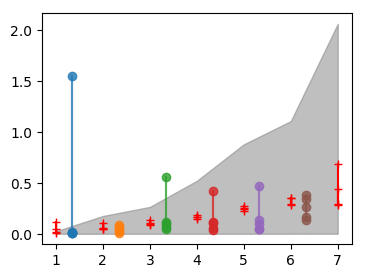

[0. 0. 0. 1. 1. 2. 2.]


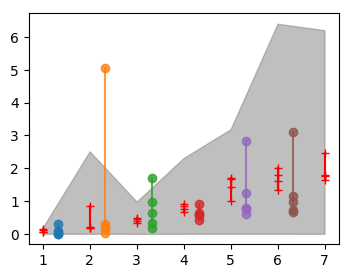

[[0. 0. 0. 1. 1. 2. 4.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 2. 2.]]
16
[ 2  3  7 11 16 19]
(90, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[-2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.]


Average Loss = 99.201: 100%|████████████████████████████████████████████████████| 20000/20000 [00:29<00:00, 677.04it/s]
Finished [100%]: Average Loss = 99.237
Average Loss = 97.22: 100%|████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1044.23it/s]
Finished [100%]: Average Loss = 97.195
Assigned BinaryGibbsMetropolis to zij
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [07:01<00:00,  8.31it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 354 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



WAIC_r(WAIC=87.61837455023706, WAIC_se=31.713952227249095, p_WAIC=18.724971344193968)
87.61837455023706
LOO_r(LOO=91.09246176422184, LOO_se=31.962633355133114, p_LOO=20.462014951186347)


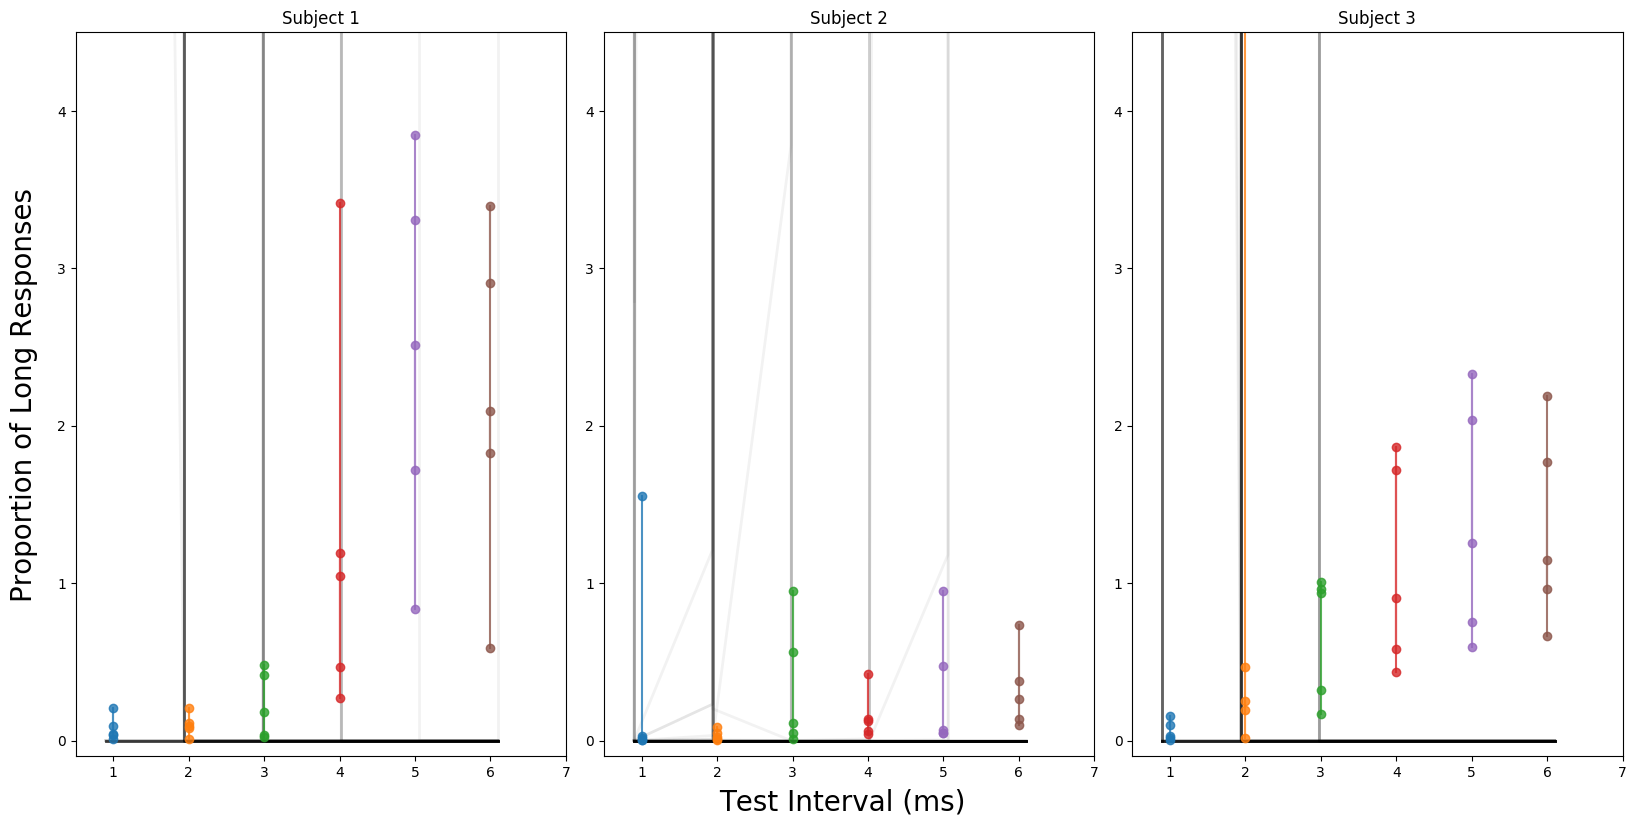

[-3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.
  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.
  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.
  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.
  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2.]
90
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2710.05it/s]


[1. 1. 1. 1. 1. 1. 1.]


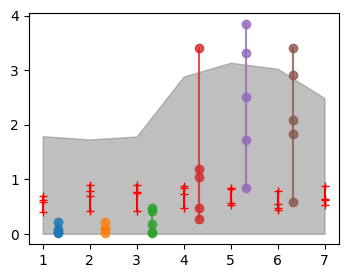

[1. 1. 1. 1. 0. 0. 1.]


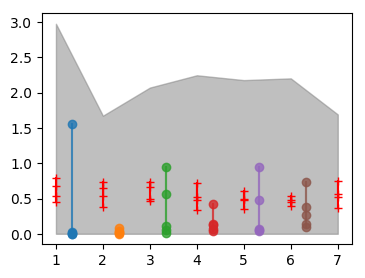

[1. 1. 1. 1. 1. 1. 1.]


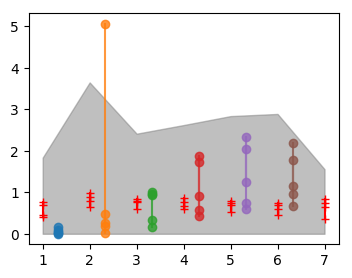

[[1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1.]]
17
[ 5  6 12 13 15 20]
(90, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[-2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.]


Average Loss = 81.781: 100%|████████████████████████████████████████████████████| 20000/20000 [00:30<00:00, 653.20it/s]
Finished [100%]: Average Loss = 81.745
Average Loss = 80.075: 100%|███████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1031.40it/s]
Finished [100%]: Average Loss = 80.085
Assigned BinaryGibbsMetropolis to zij
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [10:45<00:00,  5.42it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.6533438040834503, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 782 diverging samples after tuning. If increasing `target_accept` does not help try to re

WAIC_r(WAIC=46.85378085708686, WAIC_se=27.739891256233822, p_WAIC=24.367835916703854)
46.85378085708686
LOO_r(LOO=47.92780089626011, LOO_se=28.10820081920725, p_LOO=24.904845936290478)


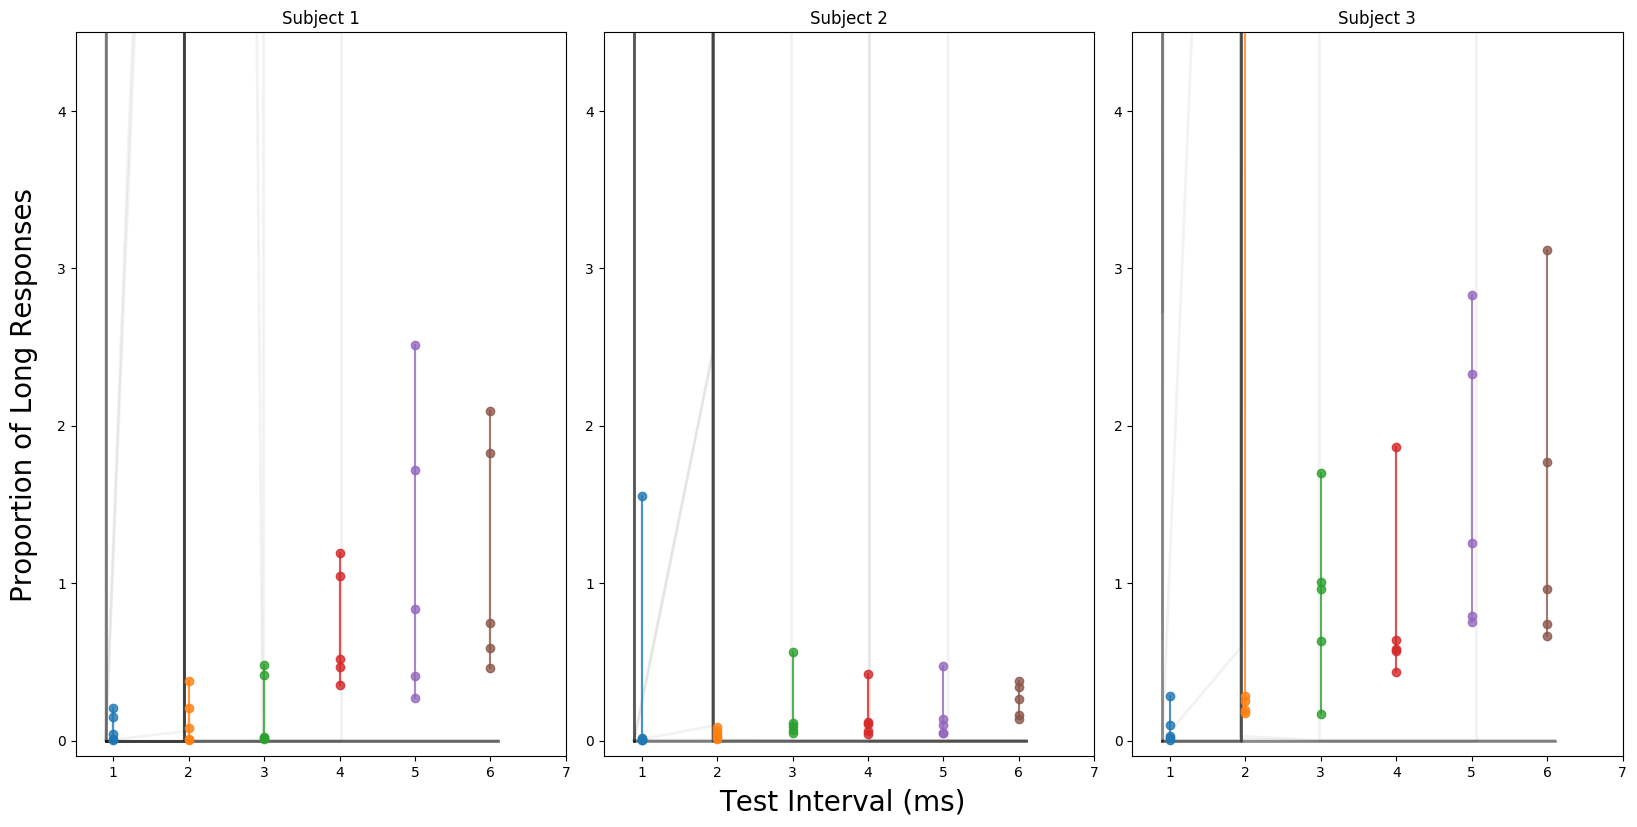

[-3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.
  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.
  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.
  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.
  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2.]
90
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2870.01it/s]


[0. 1. 1. 1. 1. 1. 0.]


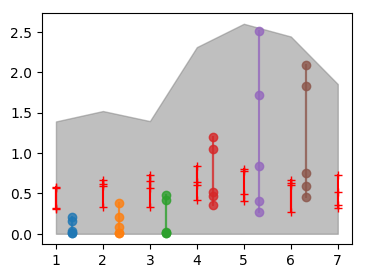

[0. 0. 0. 0. 0. 0. 1.]


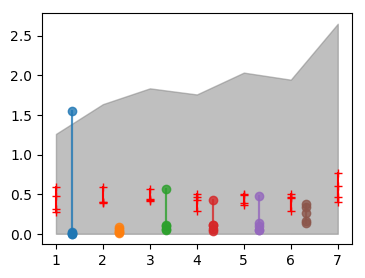

[1. 1. 1. 1. 1. 1. 1.]


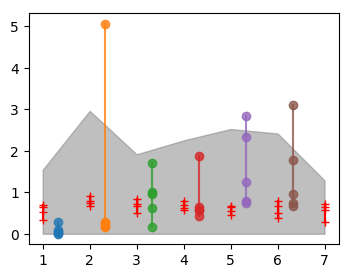

[[0. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1.]]
18
[ 1  6 11 13 14 19]
(90, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[-2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.
 -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2. -2. -2. -0.  0.  2.  2.]


Average Loss = 78.921: 100%|████████████████████████████████████████████████████| 20000/20000 [00:27<00:00, 721.85it/s]
Finished [100%]: Average Loss = 78.816
Average Loss = 77.29: 100%|████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1102.00it/s]
Finished [100%]: Average Loss = 77.303
Assigned BinaryGibbsMetropolis to zij
100%|█████████████████████████████████████████████████████████████████████████████▉| 3498/3500 [02:35<00:00, 22.43it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.5218848056572829, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 1132 diverging samples after tuning. If increasing `target_accept` does not help try to r

WAIC_r(WAIC=-24.821209175574833, WAIC_se=28.667982167714808, p_WAIC=18.16616419570782)
-24.821209175574833
LOO_r(LOO=-17.15391389139045, LOO_se=29.122932664521496, p_LOO=21.99981183780001)


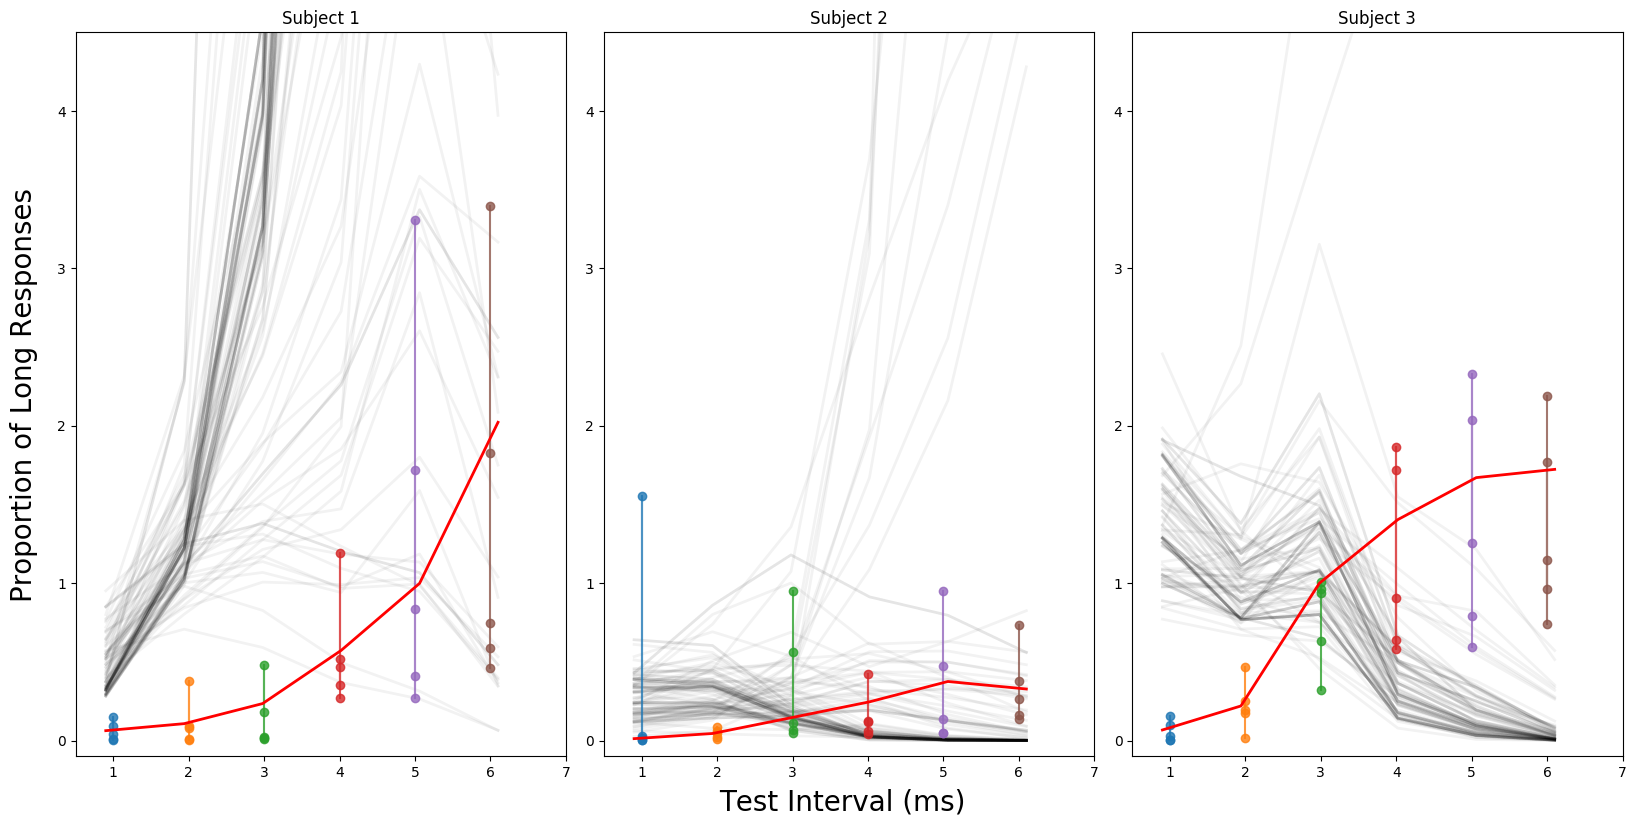

[-3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.
  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.
  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.
  0.  1.  2.  3. -3. -2. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.
  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2. -1.  0.  1.  2.  3. -3. -2.]
90
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2793.56it/s]


[0. 0. 0. 0. 1. 1. 4.]


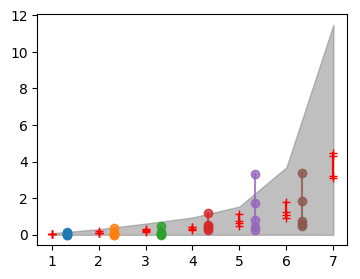

[0. 0. 0. 0. 0. 0. 1.]


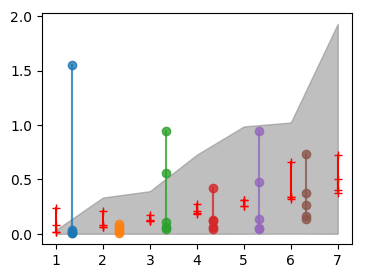

[0. 0. 0. 1. 2. 2. 1.]


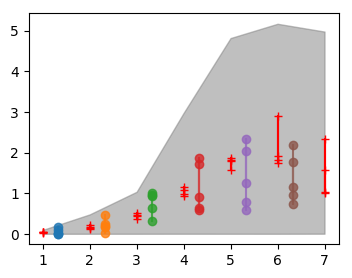

[[0. 0. 0. 0. 1. 1. 4.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 2. 2. 1.]]
19


In [4]:
Count_M2 = 20
WAIC_M2 = {}
LOO_M2 = {}
Mse_M2 = {}
Mean_Train_M2_A = [] #存放每个省的拟合的均值
Mean_Train_M2_B = [] #存放每个省的拟合的均值
Mean_Train_M2_C = [] #存放每个省的拟合的均值

Mean_Out_M2_A = [] #存放输出
Mean_Out_M2_B = [] #存放输出
Mean_Out_M2_C = [] #存放输出
for ii in np.arange(Count_M2):
# 生成随机数据==============================================================
    X = np.vstack((elec_year, elec_Pca_char1, elec_Pca_char2, companyABC)).T
    Y = elec_faults
    X_train, X_test, Y_train, Y_test = DataSplit(X, Y, test_size=.2) #随机分离原始数据
    print(np.shape(X_train))
    # print(Y_train)
    X_train_M1_year = elec_year[0:len(X_train)] #防止变为浮点数
    X_train_M2_char1 = X_train[:, 1]
    X_train_M2_char2 = X_train[:, 2]
    X_train_M1_ABC = X_train[:, 3]
    X_train_M1_ABC =[int(i) for i in X_train_M1_ABC] #防止变为浮点数
    M2_companyABC = np.array(X_train_M1_ABC)

    Y_train_M1_faults = Y_train


    # 共享变量设置
    M2_xs_char1 = shared(np.asarray(X_train_M2_char1))
    M2_xs_char2 = shared(np.asarray(X_train_M2_char2))

    M2_ys_faults = shared(np.asarray(Y_train_M1_faults))
    M2_xs_year = shared(np.asarray(X_train_M1_year))
    M2_Num_shared = shared(np.asarray(M2_companyABC))
    # M2_companyABC = companyABC

    print(M2_companyABC)
    print(X_train_M1_year)
    
# 建立子模型M2==============================================================
        # 建模，加上含污染模型对比
    with pm.Model() as model_2:
        # define priors
        sdsd = 3
        alpha = pm.HalfCauchy('alpha', 10, testval=.6)

        mu_4 = pm.Normal('mu_4', mu=0, tau=.001)
        sd_4 = pm.HalfCauchy('sd_4', sdsd)
        mu_3 = pm.Normal('mu_3', mu=0, tau=.001)
        sd_3 = pm.HalfCauchy('sd_3', sdsd)
        mu_2 = pm.Normal('mu_2', mu=0, tau=.001)
        sd_2 = pm.HalfCauchy('sd_2', sdsd)
        mu_1 = pm.Normal('mu_1', mu=0, tau=.001)
        sd_1 = pm.HalfCauchy('sd_1', sdsd)
    #     mu_0 = pm.Normal('mu_0', mu=0, tau=.001)
    #     sd_0 = pm.HalfCauchy('sd_0', 20)
    #     sd = pm.InverseGamma('sd',3, 0.0001)
        beta4 = pm.Normal('beta4', mu_4, sd_4, shape=companiesABC)
        beta3 = pm.Normal('beta3', mu_3, sd_3, shape=companiesABC)
        beta2 = pm.Normal('beta2', mu_2, sd_2, shape=companiesABC)
        beta1 = pm.Normal('beta1', mu_1, sd_1, shape=companiesABC)
        beta = pm.Normal('beta', 0, 100)
        u = pm.Uniform('u', lower=0,upper=3 )

        liner = pm.Deterministic('liner', tt.exp(u*(tt.sqrt(beta1[M2_Num_shared]**2) + tt.sqrt(beta4[M2_Num_shared]**2) ) + beta + \
                                                 (beta1[M2_Num_shared] * M2_xs_year + beta2[M2_Num_shared] * M2_xs_char1 +\
                                                  beta3[M2_Num_shared] * M2_xs_char2 + beta4[M2_Num_shared] * M2_xs_year * M2_xs_year)))

        # latent model for contamination
    #     upper = pm.HalfCauchy('upper', 10)
        sigma_p = pm.HalfCauchy('sigma_p', sdsd)
        mu_p = pm.Normal('mu_p', mu=0, tau=.001)

        probitphi = pm.Normal('probitphi', mu=mu_p, sd=sigma_p, shape=companiesABC, testval=np.ones(companiesABC))
        phii = pm.Deterministic('phii', Phi(probitphi))

        pi_ij = pm.Uniform('pi_ij', lower=0, upper=1, shape=len(M2_Num_shared.get_value()))

        zij_ = pm.theanof.tt_rng().uniform(size=M2_companyABC.shape)
        zij = pm.Deterministic('zij', tt.lt(zij_, phii[M2_Num_shared]))   

        beta_mu = pm.Deterministic('beta_mu', tt.switch(zij, liner, pi_ij))

        Observed = pm.Weibull("Observed", alpha=alpha, beta=beta_mu, observed=M2_ys_faults)  # 观测值

    import theano
    with model_2:
        s = theano.shared(pm.floatX(1))
        inference = pm.ADVI(cost_part_grad_scale=s)
        # ADVI has nearly converged
        inference.fit(n=20000)
        # It is time to set `s` to zero
        s.set_value(0)
        approx = inference.fit(n=10000)
        trace_2 = approx.sample(3000, include_transformed=True)
        elbos1 = -inference.hist
    
    
    
    njob = 1
    start = trace_2[0]
    start['zij'] = start['zij'].astype(int)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model_2.dict_to_array(stds) ** 2
    # 建模，加上含污染模型对比
    with pm.Model() as model_2b:
        # define priors
        sdsd = 3
        alpha = pm.HalfCauchy('alpha', 10, testval=.6)

        mu_4 = pm.Normal('mu_4', mu=0, tau=.001)
        sd_4 = pm.HalfCauchy('sd_4', sdsd)
        mu_3 = pm.Normal('mu_3', mu=0, tau=.001)
        sd_3 = pm.HalfCauchy('sd_3', sdsd)
        mu_2 = pm.Normal('mu_2', mu=0, tau=.001)
        sd_2 = pm.HalfCauchy('sd_2', sdsd)
        mu_1 = pm.Normal('mu_1', mu=0, tau=.001)
        sd_1 = pm.HalfCauchy('sd_1', sdsd)
        #     mu_0 = pm.Normal('mu_0', mu=0, tau=.001)
        #     sd_0 = pm.HalfCauchy('sd_0', 20)
        beta4 = pm.Normal('beta4', mu_4, sd_4, shape=companiesABC)
        beta3 = pm.Normal('beta3', mu_3, sd_3, shape=companiesABC)
        beta2 = pm.Normal('beta2', mu_2, sd_2, shape=companiesABC)
        beta1 = pm.Normal('beta1', mu_1, sd_1, shape=companiesABC)
        beta = pm.Normal('beta', 0, 100)
        u = pm.Uniform('u', lower=0,upper=3 )

        liner = pm.Deterministic('liner', tt.exp(u*(tt.sqrt(beta1[M2_Num_shared]**2) + tt.sqrt(beta4[M2_Num_shared]**2)) + beta + \
                                                 (beta1[M2_Num_shared] * M2_xs_year + beta2[M2_Num_shared] * M2_xs_char1 +\
                                                  beta3[M2_Num_shared] * M2_xs_char2 + beta4[M2_Num_shared] * M2_xs_year * M2_xs_year)))

        pi_ij = pm.Uniform('pi_ij', lower=0, upper=1, shape=len(M2_Num_shared.get_value()))

        # latent model for contamination
        sigma_p = pm.HalfCauchy('sigma_p', sdsd)
        mu_p = pm.Normal('mu_p', mu=0, tau=.001)

        probitphi = pm.Normal('probitphi', mu=mu_p, sd=sigma_p, shape=companiesABC, testval=np.ones(companiesABC))
        phii = pm.Deterministic('phii', Phi(probitphi))

        zij = pm.Bernoulli('zij', p=phii[M2_Num_shared], shape=len(M2_Num_shared.get_value()))

        beta_mu = pm.Deterministic('beta_mu', tt.switch(tt.eq(zij, 0), liner, pi_ij))

        Observed = pm.Weibull("Observed", alpha=alpha, beta=beta_mu, observed=M2_ys_faults)  # 观测值

        #     step1 = pm.Metropolis([zij])
        step = pm.NUTS(scaling=cov, is_cov=True)
        trace_2b = pm.sample(3000, step=[step], start=start, njobs=njob, turn=500)

# 子模型画图后验=============================================================  
        
    chain_2b = trace_2b[2000:]
    # varnames2 = ['beta', 'beta1', 'beta2', 'beta3', 'u', 'beta4']
#     pm.traceplot(chain_2b)
#     plt.show()
    
    
    
    varnames2b = ['beta2', 'beta3','phii']
    tmp_2b = pm.df_summary(trace_2b, varnames2b)
#     print(tmp_2b)
    Beta_Mu2b = tmp_2b['mean']

#     pm.forestplot(trace_2b, varnames=['phii'])
#     plt.show()
    
    
# 子模型拟合WAIC值计算==============================================================
    WAIC_2 = pm.waic(trace_2b, model_2b)
    print(WAIC_2)
    print(WAIC_2[0])
    WAIC_M2[ii] = WAIC_2[0]
    LOO_2 = pm.loo(trace_2b, model_2b)
    print(LOO_2)
    LOO_M2[ii] = LOO_2[0]
    
# 子模型数据计算==============================================================
    
    varnames2b = ['beta_mu']
    varnames2b = ['liner']
    tmp_mu2b = pm.df_summary(chain_2b, varnames2b)
    Beta_Mu2b = tmp_mu2b['mean']

    Beta_Mu_2b = np.array([Beta_Mu2b[i*6:(i+1)*6] for i in np.arange(15)])

    # print(Beta_Mu2b)
    # 将故障率以5组一行形式组成数组,变成：21*6
    M2_elec_faults2 = np.array([Y_train_M1_faults[i*6:(i+1)*6] for i in np.arange(15)])
    M2_elec_year2 = np.array([X_train_M1_year[i*6:(i+1)*6] for i in np.arange(15)])
    M2_elec_char1 = np.array([X_train_M2_char1[i*6:(i+1)*6] for i in np.arange(15)])
    M2_elec_char2 = np.array([X_train_M2_char2[i*6:(i+1)*6] for i in np.arange(15)])
    
    
# 子模型拟合结果显示==============================================================
    # 模型拟合效果图
    ppcsamples = 500
    ppcsize = 100
    # ppc = defaultdict(list)
    burnin = 2000
    fig = plt.figure(figsize=(16, 8))
    fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center', fontsize=20)
    fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical', fontsize=20)
    gs = gridspec.GridSpec(1, 3)
    ppcsamples = 100


    for ip in np.arange(companiesABC):
        ax = plt.subplot(gs[ip])
        xp = M2_elec_year2[ip*5:(ip+1)*5, :] + Add_year_Mean
        yp = M2_elec_faults2[ip*5:(ip+1)*5, :]


        xl = np.linspace(0.9, 6.1, 6)
    #     yl = Beta_Mu2[ip*7:(ip+1)*7, :]
    #     yl = yl.mean(axis=0)

        y2 = Beta_Mu_2b[ip*5:(ip+1)*5, :]
        y2 = y2.mean(axis=0)
        if WAIC_2[0]<10:
            if ip==0:
                Mean_Train_M2_A.append(y2)
            if ip==1:
                Mean_Train_M2_B.append(y2)
            if ip==2:
                Mean_Train_M2_C.append(y2)
        # Posterior sample from the trace
        for ips in np.random.randint(burnin, 3000, ppcsamples):
            param = trace_2b[ips]

            yl2 = np.exp(param['u']*(np.sqrt(param['beta1'][ip]*param['beta1'][ip] + param['beta4'][ip]**2)) + param['beta'] + (param['beta1'][ip] * (xl) + \
                         param['beta2'][ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                         param['beta3'][ip]*elec_Pca_char2[ip*42:(ip*42+6)] + \
                          + param['beta4'][ip] *xl*xl)
                        )
            ax.plot(xl, yl2, 'k', linewidth=2, alpha=.05)

    #     ax = sns.violinplot(data=elec_faults2[ip*7:(ip+1)*7])
        ax.plot(xp, yp, marker='o', alpha=.8)
    #     plt.plot(xl, yl, 'k--', linewidth=2)
        plt.plot(xl, y2,  'r', linewidth=2)
        plt.axis([0.5, 7, -.1, 4.5])
        plt.title('Subject %s' % (ip + 1))

    plt.tight_layout()
    plt.show()
    
    

    
# 子模型测试第7年数据==============================================================
    # 第七年数据测试，读取测试数据集特征,
    data_cs = pd.read_csv('XZ_CS_5.csv')
    SNR_cs = np.random.normal(0, 2, size=[len(data_cs.Tem.values), 4])
    datax_cs = np.array(data_cs)[:,0:4] + SNR_cs # 针对特征添加噪声

    data_cs_year = data_cs.Year.values # 测试数据时间
    data_cs_year_Mean = data_cs_year.mean()
    data_cs_year = data_cs_year - data_cs_year_Mean

    data_cs_num  = data_cs.Count.values # 测试数据参考位置,这么做就是整数

    data_cs_num1 =[int(i) for i in data_cs_num] #防止变为64位整数
    data_cs_num2 = np.array(data_cs_num1)

    meanVal = np.mean(datax_cs, axis=0)  # 按列求均值，即求各个特征的均值
    newData_mean = datax_cs - meanVal
    StdVal  = np.std(datax_cs, axis=0)
    newData_std = newData_mean/StdVal


    pca = PCA(n_components=2)
    pca.fit(newData_std)
    Pca_cs = pca.transform(newData_std) # 测试数据PCA特征值，直接调用即可，但是之调用这条也会出问题
    Pca_cs_char1 = Pca_cs[:, 0]
    Pca_cs_char2 = Pca_cs[:, 1]
    print(data_cs_year)
    print(len(data_cs_year))
    print(data_cs_num)
    
    
    
    
    
# 子模型测试数据结果显示==============================================================
    # 测试数据结果显示

    M2_xs_year.set_value(np.asarray(data_cs_year))
    M2_Num_shared.set_value(np.asarray(data_cs_num2))
    M2_xs_char1.set_value(np.asarray(Pca_cs_char1))
    M2_xs_char2.set_value(np.asarray(Pca_cs_char2))


    with model_2b:
        ppcc = pm.sample_ppc(trace_2b)
    # print(ppcc)
    post_pred = ppcc['Observed']
    yipred_mean = post_pred.mean(axis=0)  # 预测均值
    # print(yipred_mean)
    # 这句话要改
    sig0 = pm.hpd(post_pred, alpha=0.05)   # 预测置信区间
    M2_sig0 = pm.hpd(post_pred, alpha=0.05)   # 预测置信区间
    # plt.fill_between(xp, sig0[:,0], sig01[:,1], color='gray', alpha=.8)  
    # print(sig0)
    # 预测，此时这种格式是每行列数len(elec_faults)个，有很多行数据
    xipred={}

    fig = plt.figure(figsize=(4, 3))
    ax = plt.subplot(1, 1, 1)
    ip = 0
    xp = M2_elec_year2[ip*5:(ip+1)*5, :] + data_cs_year_Mean  #原始数据
    yp = M2_elec_faults2[ip*5:(ip+1)*5, :]
    ax.plot(xp, yp, marker='o', alpha=.8)

    xp_0 = [1,2,3,4,5,6,7]

    plt.fill_between(xp_0, sig0[:7,0], sig0[:7,1], color='gray', alpha=.5) 

    yipred_yplot = np.array([yipred_mean[i*7:(i+1)*7] for i in np.arange(4*ip, (ip+1)*4)])
    M2_Pred_yplot_Mean_A = yipred_yplot.mean(axis=0)
    print(M2_Pred_yplot_Mean_A)
    xipred = np.array([np.arange(7)+1 for i in np.arange(4)])
    ax.plot(xipred, yipred_yplot[:], 'k+-', color='r')  
    # plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred0.png', dpi = 200, bbox_inches='tight')
    plt.show()


    fig = plt.figure(figsize=(4, 3))
    ax = plt.subplot(1, 1, 1)
    ip = 1
    xp = M2_elec_year2[ip*5:(ip+1)*5, :] + data_cs_year_Mean#原始数据
    yp = M2_elec_faults2[ip*5:(ip+1)*5, :]
    ax.plot(xp, yp, marker='o', alpha=.8)

    plt.fill_between(xp_0, sig0[30:37,0], sig0[30:37,1], color='gray', alpha=.5) 

    yipred_yplot = np.array([yipred_mean[(i*7+2):((i+1)*7+2)] for i in np.arange(4*ip, (ip+1)*4)])
    M2_Pred_yplot_Mean_B = yipred_yplot.mean(axis=0)
    print(M2_Pred_yplot_Mean_B)
    xipred = np.array([np.arange(7)+1 for i in np.arange(4)])
    ax.plot(xipred, yipred_yplot[:], 'k+-', color='r') 
    # plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred1.png', dpi = 200, bbox_inches='tight')
    plt.show()


    fig = plt.figure(figsize=(4, 3))
    ax = plt.subplot(1, 1, 1)
    ip = 2
    xp = M2_elec_year2[ip*5:(ip+1)*5, :] + data_cs_year_Mean #原始数据
    yp = M2_elec_faults2[ip*5:(ip+1)*5, :]
    ax.plot(xp, yp, marker='o', alpha=.8)

    plt.fill_between(xp_0, sig0[60:67,0], sig0[60:67,1], color='gray', alpha=.5)  

    yipred_yplot = np.array([yipred_mean[(i*7+4):((i+1)*7+4)] for i in np.arange(4*ip, (ip+1)*4)])
    M2_Pred_yplot_Mean_C = yipred_yplot.mean(axis=0)
    print(M2_Pred_yplot_Mean_C)
    xipred = np.array([np.arange(7)+1 for i in np.arange(4)])
    ax.plot(xipred, yipred_yplot[:], 'k+-', color='r')

    # plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred2.png', dpi = 200, bbox_inches='tight')
    plt.show()


    M2_Pred_y_Mean_C = np.vstack((M2_Pred_yplot_Mean_A, M2_Pred_yplot_Mean_B, M2_Pred_yplot_Mean_C))
    print(M2_Pred_y_Mean_C)
    # np.savetxt('M2_Pred_yplot_Mean_C.csv', M2_Pred_yplot_Mean_C, delimiter = ',')
    
    if WAIC_2[0]<10:
        Mean_Out_M2_A.append(M2_Pred_yplot_Mean_A[-1]) #预测输出值，针对每个省
        Mean_Out_M2_B.append(M2_Pred_yplot_Mean_B[-1])
        Mean_Out_M2_C.append(M2_Pred_yplot_Mean_C[-1])
    print(ii)
#     Mse_M2[ii] = MSE(elec_faults, Mean_out_M2, Len_One=6, Zoom_factor=100)

In [5]:
print(WAIC_M2)
print(LOO_M2)
print('\n')
print(Mean_Out_M2_A)
print(Mean_Out_M2_B)
print(len(Mean_Out_M2_C))
# Mean_Train_M2_BB = np.mean(Mean_Train_M2_B, axis=0)
# print(Mean_Train_M2_BB)

# print(Mean_Train_M2_A)

{0: 0.6880534831168061, 1: -7.645625190155211, 2: 50.855333019101096, 3: -19.31954098110834, 4: -6.937250117761666, 5: -1.2551164993408093, 6: -28.12677139298155, 7: 55.52038181226556, 8: 52.80053957803956, 9: 1.650199440373787, 10: 79.24431278488758, 11: 19.620341572728208, 12: -15.287220803110188, 13: -1.7802483675489365, 14: 36.90482282416642, 15: 37.16934445920046, 16: -12.627420022740582, 17: 87.61837455023706, 18: 46.85378085708686, 19: -24.821209175574833}
{0: 7.413536641490546, 1: -1.292385933940035, 2: 52.879781142664754, 3: -14.65713971998672, 4: -3.583745049068715, 5: 5.055611108809176, 6: -24.168686780296536, 7: 57.23646904228043, 8: 53.43461804345309, 9: 10.859549327371404, 10: 81.57420278295508, 11: 25.845039563026567, 12: -9.942376857899845, 13: 6.845292701242573, 14: 46.52398720938923, 15: 42.158996056296346, 16: -4.950203469239366, 17: 91.09246176422184, 18: 47.92780089626011, 19: -17.15391389139045}


[3.3318617179186454, 4.652258146461227, 2.3173468613722776, 3.37383

In [6]:
# WAIC_M2.pop(6)
# Mean_Out_M2_A为第7年预测输出
Mean_Cumul_M2 = np.vstack((Mean_Out_M2_A, Mean_Out_M2_B, Mean_Out_M2_C))
print(WAIC_M2)
print(Mean_Cumul_M2)
print(len(Mean_Cumul_M2[0]))
np.savetxt('Mean_Cumul_M21.csv', Mean_Cumul_M2, delimiter = ',') #Mean_Cumul_M21为临时文件，需要拷到Mean_Cumul_M2文件中再删除

{0: 0.6880534831168061, 1: -7.645625190155211, 2: 50.855333019101096, 3: -19.31954098110834, 4: -6.937250117761666, 5: -1.2551164993408093, 6: -28.12677139298155, 7: 55.52038181226556, 8: 52.80053957803956, 9: 1.650199440373787, 10: 79.24431278488758, 11: 19.620341572728208, 12: -15.287220803110188, 13: -1.7802483675489365, 14: 36.90482282416642, 15: 37.16934445920046, 16: -12.627420022740582, 17: 87.61837455023706, 18: 46.85378085708686, 19: -24.821209175574833}
[[3. 5. 2. 3. 4. 6. 2. 3. 5. 4. 4.]
 [1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
 [2. 1. 2. 2. 2. 2. 2. 1. 2. 2. 1.]]
11


In [7]:
Mean_Cumul_M2 = np.loadtxt('Mean_Cumul_M2.csv', delimiter = ',')
print(Mean_Cumul_M2)
print(len(Mean_Cumul_M2))

# 对第7年预测值进行累加计算
PredMean_Cumul_M2 = []
for j in range(len(Mean_Cumul_M2)):
    MeanCumul_Value = []
    for i in range(len(Mean_Cumul_M2[0])):
        MeanCumul_Value.append(sum(Mean_Cumul_M2[j, jj] for jj in range(i+1))/(i+1) )
#         print(MeanCumul_Value)
    PredMean_Cumul_M2.append(MeanCumul_Value)
print(PredMean_Cumul_M2)


[[7. 4. 4. 4. 4. 3. 4. 3. 4. 4. 4. 5. 4. 4. 4. 5. 2. 3. 2. 3. 2. 3. 3. 3.
  4. 3. 3. 5. 2. 2. 2. 3. 4. 3. 2. 3. 3. 5. 3. 3. 5. 3. 3. 2. 2. 4. 2. 3.
  2. 3. 4. 4. 4. 3. 4. 4. 3. 3. 6. 3. 4. 2. 2. 4. 4. 5. 5. 2. 3. 2. 3. 2.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [4. 2. 2. 1. 2. 2. 1. 3. 2. 2. 2. 2. 2. 1. 1. 2. 1. 2. 1. 1. 1. 2. 2. 2.
  1. 2. 1. 2. 2. 2. 1. 2. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 2. 1. 2. 1. 1. 2.
  1. 2. 3. 2. 2. 1. 2. 5. 1. 2. 2. 2. 1. 2. 4. 2. 1. 1. 1. 2. 2. 2. 2. 2.]]
3
[[6.99, 5.445, 4.930000000000001, 4.720000000000001, 4.482000000000001, 4.210000000000001, 4.11, 3.9725, 3.967777777777778, 3.942, 3.9781818181818185, 4.0441666666666665, 4.0053846153846155, 4.0, 3.9806666666666666, 4.065625, 3.9529411764705884, 3.926111111111111, 3.808947368421053, 3.7865, 3.723333333333333, 3.680454545454545

Rmse Mean is A、B、C :
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]


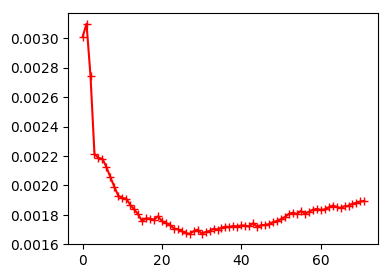

In [8]:
# 计算预测的累计均方误差
# 读取第7年的实际数据
Pred_Data = pd.read_csv('XZmulti_6_Only7Test.csv')
Pred_faults = 100 * (Pred_Data.Fault.values / Pred_Data.Nums.values)  # 数组形式,计算故障率大小


def Rmse(predictions, targets):
    return np.sqrt(np.mean((predictions - targets) ** 2))

def RMSEfor_Pred1(Faults, FitValue, Len_One=7, Zoom_factor=100):
    Len_Faults = np.shape(Faults)
    Len_Fault = round(Len_Faults[0] / Len_One)  # round取整数，Len_Fault = 21/7 = 3

    Faults = Faults / Zoom_factor  # 还原数据
    FitValue = np.array(FitValue)
#     print(FitValue)
    FitValue = FitValue / Zoom_factor  # 还原数据
#     Faults_Col为 3*7的数组，3行7列
    Faults_Col = np.array([Faults[i * Len_One:(i + 1) * Len_One] for i in np.arange(Len_Fault)])  # 将输入数据排列好
#     FitValue为3行,未知长度
    Mean_Rmse = []
    for i in np.arange(3):
        Rmse_Value = []
        for jj in np.arange(len(FitValue[0])):
            A = Rmse(Faults_Col[i], FitValue[i, jj])  # 计算每组的均方根误差
            Rmse_Value = np.append(Rmse_Value, A)  # 计算每组的均方根误差
        # print(Rmse_Value)
        Mean_Rmse.append(Rmse_Value)   # 计算每省的均方根误差
    # print(Mean_Rmse)
    print('Rmse Mean is A、B、C :')
    return Mean_Rmse
# 计算第7年的累计均方误差
MseMeanPred_all = RMSEfor_Pred1(Pred_faults, PredMean_Cumul_M2)
# print(MseMeanPred_all)
# np.savetxt('MseMeanPred_all.csv', MseMeanPred_all, delimiter = ',')
fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
xl = np.arange(len(MseMeanPred_all[0]))
print(xl)
ax.plot(xl, MseMeanPred_all[1], 'k+-', color='r')
plt.show()

In [11]:
# 计算拟合时的累计均方误差
# Mean_Train_M2_A为每次拟合时存储的6年数据值
# Mean_Train_M2_A1.csv为中间变量，需要删除的
Mean_Train_M2_A = np.array(Mean_Train_M2_A)
Mean_Train_M2_B = np.array(Mean_Train_M2_B)
Mean_Train_M2_C = np.array(Mean_Train_M2_C)
np.savetxt('Mean_Train_M2_A1.csv', Mean_Train_M2_A, delimiter = ',')
np.savetxt('Mean_Train_M2_B1.csv', Mean_Train_M2_B, delimiter = ',')
np.savetxt('Mean_Train_M2_C1.csv', Mean_Train_M2_C, delimiter = ',')

Mean_Train_M2_A = np.loadtxt('Mean_Train_M2_A.csv',delimiter = ',')
Mean_Train_M2_B = np.loadtxt('Mean_Train_M2_B.csv',delimiter = ',')
Mean_Train_M2_C = np.loadtxt('Mean_Train_M2_C.csv',delimiter = ',')

print(Mean_Train_M2_A[0])
MeanTrain_Cumul_M2 = np.vstack((Mean_Train_M2_A, Mean_Train_M2_B, Mean_Train_M2_C))
# print(MeanTrain_Cumul_M2)
print(len(MeanTrain_Cumul_M2))
LenTrain_M2 = int(len(MeanTrain_Cumul_M2)/3) #总长度除以3，每省的训练数据长度
print(LenTrain_M2)

# 对拟合进行累加计算
TrainMeanCumul_ValueA =[]
TrainMeanCumul_ValueB =[]
TrainMeanCumul_ValueC =[]
for j in range(3):#3个省数据总长度
    A = MeanTrain_Cumul_M2[(j*LenTrain_M2):((j+1)*LenTrain_M2), ]
    for i in range(LenTrain_M2):        #每个省数据总长度
        if j==0:
            TrainMeanCumul_ValueA.append(sum(A[jj] for jj in range(i+1))/(i+1) )
        if j==1:
            TrainMeanCumul_ValueB.append(sum(A[jj] for jj in range(i+1))/(i+1) )
        if j==2:
            TrainMeanCumul_ValueC.append(sum(A[jj] for jj in range(i+1))/(i+1) )
print(TrainMeanCumul_ValueC)
print(np.shape(TrainMeanCumul_ValueA))

[0. 0. 0. 1. 2. 3.]
177
59
[array([0., 0., 1., 2., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 2., 2., 2.]), array([0., 0., 1., 2., 2., 2.]), array([0., 0., 1., 2., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 1., 1., 2., 2.]), array([0., 0., 

Rmse Mean is A、B、C :
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58]


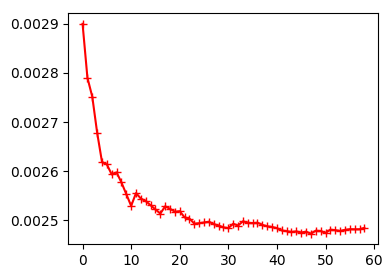

In [16]:
# 计算6年拟合值的累计误差
# 输入Faults：原始数据单维
# FitValueA：A省累计训练数组，2维度
def RMSEfor_Train(Faults, FitValueA, FitValueB, FitValueC, Len_One=6, Zoom_factor=100):
    Len_Faults = np.shape(Faults)
    Len_Fault = round(Len_Faults[0] / Len_One)  # round取整数，Len_Fault = 21/7 = 3

    Faults = Faults / Zoom_factor  # 还原数据
    FitValueA = np.array(FitValueA)
    FitValueA = FitValueA / Zoom_factor  # 还原数据
    FitValueB = np.array(FitValueB)
    FitValueB = FitValueB / Zoom_factor  # 还原数据
    FitValueC = np.array(FitValueC)
    FitValueC = FitValueC / Zoom_factor  # 还原数据
    #     Faults_Col为 3*7的数组，3行21列
    Faults_Col = np.array([Faults[i * Len_One:(i + 1) * Len_One] for i in np.arange(Len_Fault)])  # 将输入数据排列好
#     print(Faults_Col)
    Mean_RmseA = []
    for jj in np.arange(len(FitValueA)):
        Rmse_Value = []
        for i in np.arange(7):
            A = Rmse(Faults_Col[i], FitValueA[jj])  # 计算每组的均方根误差
            Rmse_Value = np.append(Rmse_Value, A)  # 计算每组的均方根误差
            # print(Rmse_Value)
        Mean_RmseA.append(Rmse_Value.mean(axis=0))   # 计算每省的均方根误差
#     print(Mean_RmseA)
    
    Mean_RmseB = []
    for jj in np.arange(len(FitValueB)):
        Rmse_Value = []
        for i in np.arange(7):
            A = Rmse(Faults_Col[i+7], FitValueB[jj])  # 计算每组的均方根误差
            Rmse_Value = np.append(Rmse_Value, A)  # 计算每组的均方根误差
#             print(Rmse_Value)
        Mean_RmseB.append(Rmse_Value.mean(axis=0))   # 计算每省的均方根误差
#     print(Mean_RmseB)
    
    Mean_RmseC = []
    for jj in np.arange(len(FitValueC)):
        Rmse_Value = []
        for i in np.arange(7):
            A = Rmse(Faults_Col[i+14], FitValueC[jj])  # 计算每组的均方根误差
            Rmse_Value = np.append(Rmse_Value, A)  # 计算每组的均方根误差
#             print(Rmse_Value)
        Mean_RmseC.append(Rmse_Value.mean(axis=0))   # 计算每省的均方根误差
#     print(Mean_RmseC)
    MeanTrain_Out_M2 = np.vstack((Mean_RmseA, Mean_RmseB, Mean_RmseC))
#     print(MeanTrain_Out_M2)
    print('Rmse Mean is A、B、C :')
    return MeanTrain_Out_M2

Train_Output_M2 = RMSEfor_Train(elec_faults, TrainMeanCumul_ValueA, TrainMeanCumul_ValueB, TrainMeanCumul_ValueC)
print(Train_Output_M2)

fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
xl = np.arange(len(Train_Output_M2[0]))
print(xl)
ax.plot(xl, Train_Output_M2[1], 'k+-', color='r')
plt.show()

Bayesian 子模型2
---

In [ ]:
Count_M3 = 3
WAIC_M3 = {}
LOO_M3 = {}
for ii in np.arange(Count_M3):
    X = np.vstack((elec_year, elec_Pca_char1, elec_Pca_char2, companyABC)).T
    Y = elec_faults
    M3_X_train, X_test, M3_Y_train, Y_test = DataSplit(X, Y, test_size=.2) #随机分离原始数据
    print(np.shape(X_train))
    # print(Y_train)
    X_train_M1_year = elec_year[0:len(X_train)] #防止变为浮点数
    X_train_M3_char1 = M3_X_train[:, 1]
    X_train_M3_char2 = M3_X_train[:, 2]
    X_train_M1_ABC = M3_X_train[:, 3]
    X_train_M1_ABC =[int(i) for i in X_train_M1_ABC] #防止变为浮点数
    M3_companyABC = np.array(X_train_M1_ABC)

    Y_train_M1_faults = M3_Y_train


    # 共享变量设置
    M3_xs_char1 = shared(np.asarray(X_train_M3_char1))
    M3_xs_char2 = shared(np.asarray(X_train_M3_char2))

    M3_ys_faults = shared(np.asarray(Y_train_M1_faults))
    M3_xs_year = shared(np.asarray(X_train_M1_year))
    M3_Num_shared = shared(np.asarray(M3_companyABC))

    print(M3_companyABC)
    print(X_train_M1_year)
    
    
    
    
    # 建模，加上含污染模型对比
    with pm.Model() as model_3:
        # define priors
        sdsd = 3
        M3_alpha = pm.HalfCauchy('M3_alpha', 10, testval=.6)

        M3_mu_4 = pm.Normal('M3_mu_4', mu=0, tau=.001)
        M3_sd_4 = pm.HalfCauchy('M3_sd_4', sdsd)
        M3_mu_3 = pm.Normal('M3_mu_3', mu=0, tau=.001)
        M3_sd_3 = pm.HalfCauchy('M3_sd_3', sdsd)
        M3_mu_2 = pm.Normal('M3_mu_2', mu=0, tau=.001)
        M3_sd_2 = pm.HalfCauchy('M3_sd_2', sdsd)
        M3_mu_1 = pm.Normal('M3_mu_1', mu=0, tau=.001)
        M3_sd_1 = pm.HalfCauchy('M3_sd_1', sdsd)
    #     mu_0 = pm.Normal('mu_0', mu=0, tau=.001)
    #     sd_0 = pm.HalfCauchy('sd_0', 20)
    #     sd = pm.InverseGamma('sd',3, 0.0001)
        beta4 = pm.Normal('beta4', M3_mu_4, M3_sd_4, shape=companiesABC)
        beta3 = pm.Normal('beta3', M3_mu_3, M3_sd_3, shape=companiesABC)
        beta2 = pm.Normal('beta2', M3_mu_2, M3_sd_2, shape=companiesABC)
        beta1 = pm.Normal('beta1', M3_mu_1, M3_sd_1, shape=companiesABC)
        beta = pm.Normal('beta', 0, 100)
        u = pm.Uniform('u', lower=0,upper=3 )

        liner = pm.Deterministic('liner', tt.exp(u*(tt.sqrt(beta1[M3_Num_shared]**2 + beta4[M3_Num_shared]**2)) + beta + \
                                                 (beta1[M3_Num_shared] * M3_xs_year + beta2[M3_Num_shared] * M3_xs_char1 +\
                                                  beta3[M3_Num_shared] * M3_xs_char2 + beta4[M3_Num_shared] * M3_xs_year * M3_xs_year)))

        # latent model for contamination
    #     upper = pm.HalfCauchy('upper', 10)
        M3_sigma_p = pm.HalfCauchy('M3_sigma_p', sdsd)
        M3_mu_p = pm.Normal('M3_mu_p', mu=0, tau=.001)

        probitphi = pm.Normal('probitphi', mu=M3_mu_p, sd=M3_sigma_p, shape=companiesABC, testval=np.ones(companiesABC))
        phii = pm.Deterministic('phii', Phi(probitphi))

        pi_ij = pm.Uniform('pi_ij', lower=0, upper=1, shape=len(M3_Num_shared.get_value()))

        zij_ = pm.theanof.tt_rng().uniform(size=M3_companyABC.shape)
        zij = pm.Deterministic('zij', tt.lt(zij_, phii[M3_Num_shared]))   

        M3_beta_mu = pm.Deterministic('M3_beta_mu', tt.switch(zij, liner, pi_ij))

        M3_Observed = pm.Weibull("M3_Observed", alpha=M3_alpha, beta=M3_beta_mu, observed=M3_ys_faults)  # 观测值

    import theano
    with model_3:
        s = theano.shared(pm.floatX(1))
        inference = pm.ADVI(cost_part_grad_scale=s)
        # ADVI has nearly converged
        inference.fit(n=20000)
        # It is time to set `s` to zero
        s.set_value(0)
        approx = inference.fit(n=10000)
        trace_3 = approx.sample(3000, include_transformed=True)
        elbos1 = -inference.hist




    njob = 1
    start = trace_3[0]
    start['zij'] = start['zij'].astype(int)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model_3.dict_to_array(stds) ** 2
    # 建模，加上含污染模型对比
    with pm.Model() as model_3b:
        # define priors
        sdsd = 3
        M3_alpha = pm.HalfCauchy('M3_alpha', 10, testval=.6)

        M3_mu_4 = pm.Normal('M3_mu_4', mu=0, tau=.001)
        M3_sd_4 = pm.HalfCauchy('M3_sd_4', sdsd)
        M3_mu_3 = pm.Normal('M3_mu_3', mu=0, tau=.001)
        M3_sd_3 = pm.HalfCauchy('M3_sd_3', sdsd)
        M3_mu_2 = pm.Normal('M3_mu_2', mu=0, tau=.001)
        M3_sd_2 = pm.HalfCauchy('M3_sd_2', sdsd)
        M3_mu_1 = pm.Normal('M3_mu_1', mu=0, tau=.001)
        M3_sd_1 = pm.HalfCauchy('M3_sd_1', sdsd)
        #     mu_0 = pm.Normal('mu_0', mu=0, tau=.001)
        #     sd_0 = pm.HalfCauchy('sd_0', 20)
        beta4 = pm.Normal('beta4', M3_mu_4, M3_sd_4, shape=companiesABC)
        beta3 = pm.Normal('beta3', M3_mu_3, M3_sd_3, shape=companiesABC)
        beta2 = pm.Normal('beta2', M3_mu_2, M3_sd_2, shape=companiesABC)
        beta1 = pm.Normal('beta1', M3_mu_1, M3_sd_1, shape=companiesABC)
        beta = pm.Normal('beta', 0, 100)
        u = pm.Uniform('u', lower=0,upper=3 )

        liner = pm.Deterministic('liner', tt.exp(u*(tt.sqrt(beta1[M3_Num_shared]**2 + beta4[M3_Num_shared]**2)) + beta + \
                                                 (beta1[M3_Num_shared] * M3_xs_year + beta2[M3_Num_shared] * M3_xs_char1 +\
                                                  beta3[M3_Num_shared] * M3_xs_char2 + beta4[M3_Num_shared] * M3_xs_year * M3_xs_year)))

        pi_ij = pm.Uniform('pi_ij', lower=0, upper=1, shape=len(M3_Num_shared.get_value()))

        # latent model for contamination
        M3_sigma_p = pm.HalfCauchy('M3_sigma_p', sdsd)
        M3_mu_p = pm.Normal('M3_mu_p', mu=0, tau=.001)

        probitphi = pm.Normal('probitphi', mu=M3_mu_p, sd=M3_sigma_p, shape=companiesABC, testval=np.ones(companiesABC))
        phii = pm.Deterministic('phii', Phi(probitphi))

        zij = pm.Bernoulli('zij', p=phii[M3_Num_shared], shape=len(M3_Num_shared.get_value()))

        M3_beta_mu = pm.Deterministic('M3_beta_mu', tt.switch(tt.eq(zij, 0), liner, pi_ij))

        M3_Observed = pm.Weibull("M3_Observed", alpha=M3_alpha, beta=M3_beta_mu, observed=M3_ys_faults)  # 观测值

        #     step1 = pm.Metropolis([zij])
        step = pm.NUTS(scaling=cov, is_cov=True)
        trace_3b = pm.sample(3000, step=[step], start=start, njobs=njob, turn=500)



    chain_3b = trace_3b[2000:]
    # varnames2 = ['beta', 'beta1', 'beta2', 'beta3', 'u', 'beta4']
    pm.traceplot(chain_3b)
    plt.show()




    varnames3b = ['phii']
    tmp_3b = pm.df_summary(chain_3b, varnames3b)
    print(tmp_3b)
    pm.forestplot(trace_3b, varnames=['phii'])
    plt.show()


    WAIC_3 = pm.waic(trace_3b, model_3b)
    print(WAIC_3)
    print(WAIC_3[0])
    LOO_3 = pm.loo(trace_3b, model_3b)
    print(LOO_3)
    
    WAIC_M3[ii] = WAIC_3[0]
    LOO_M3[ii] = LOO_3[0]

    varnames3b = ['M3_beta_mu']
    varnames3b = ['liner']
    tmp_mu3b = pm.df_summary(chain_3b, varnames3b)
    Beta_Mu3b = tmp_mu3b['mean']

    Beta_Mu_3b = np.array([Beta_Mu3b[i*6:(i+1)*6] for i in np.arange(15)])

    # print(Beta_Mu2b)
    # 将故障率以5组一行形式组成数组,变成：21*6
    M3_elec_faults2 = np.array([Y_train_M1_faults[i*6:(i+1)*6] for i in np.arange(15)])
    M3_elec_year2 = np.array([X_train_M1_year[i*6:(i+1)*6] for i in np.arange(15)])
    M3_elec_char1 = np.array([X_train_M3_char1[i*6:(i+1)*6] for i in np.arange(15)])
    M3_elec_char2 = np.array([X_train_M3_char2[i*6:(i+1)*6] for i in np.arange(15)])



    # 模型拟合效果图
    ppcsamples = 500
    ppcsize = 100
    # ppc = defaultdict(list)
    burnin = 2000
    fig = plt.figure(figsize=(16, 8))
    fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center', fontsize=20)
    fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical', fontsize=20)
    gs = gridspec.GridSpec(1, 3)
    ppcsamples = 100

    for ip in np.arange(companiesABC):
        ax = plt.subplot(gs[ip])
        xp = M3_elec_year2[ip*5:(ip+1)*5, :] + Add_year_Mean
        yp = M3_elec_faults2[ip*5:(ip+1)*5, :]

        xl = np.linspace(-3, 3, 6)
        x2 = np.linspace(0.9, 6.1, 6)

        y2 = Beta_Mu_3b[ip*5:(ip+1)*5, :]
        y2 = y2.mean(axis=0)
        # Posterior sample from the trace
        for ips in np.random.randint(burnin, 3000, ppcsamples):
            param = trace_3b[ips]
            yl2 = np.exp(param['u']*(np.sqrt(param['beta1'][ip]*param['beta1'][ip] + param['beta4'][ip]**2)) + param['beta'] + (param['beta1'][ip] * (xl) + \
                         param['beta2'][ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                         param['beta3'][ip]*elec_Pca_char2[ip*42:(ip*42+6)] + \
                          + param['beta4'][ip] *xl*xl)
                        )
            ax.plot(x2, yl2, 'k', linewidth=2, alpha=.05)

    #     ax = sns.violinplot(data=elec_faults2[ip*7:(ip+1)*7])
        ax.plot(xp, yp, marker='o', alpha=.8)
    #     plt.plot(xl, yl, 'k--', linewidth=2)
        plt.plot(x2, y2,  'r', linewidth=2)
        plt.axis([0.5, 7, -.1, 4.5])
        plt.title('Subject %s' % (ip + 1))

    plt.tight_layout()
    plt.show()






    # 测试数据结果显示

    M3_xs_year.set_value(np.asarray(data_cs_year))
    M3_Num_shared.set_value(np.asarray(data_cs_num2))
    M3_xs_char1.set_value(np.asarray(Pca_cs_char1))
    M3_xs_char2.set_value(np.asarray(Pca_cs_char2))


    with model_3b:
        ppcc = pm.sample_ppc(trace_3b)
    # print(ppcc)
    post_pred = ppcc['M3_Observed']
    yipred_mean = post_pred.mean(axis=0)  # 预测均值
    # print(yipred_mean)
    # 这句话要改
    sig0 = pm.hpd(post_pred, alpha=0.05)   # 预测置信区间
    M3_sig0 = pm.hpd(post_pred, alpha=0.05)   # 预测置信区间
    # plt.fill_between(xp, sig0[:,0], sig01[:,1], color='gray', alpha=.8)  
    # print(sig0)
    # 预测，此时这种格式是每行列数len(elec_faults)个，有很多行数据
    xipred={}

    fig = plt.figure(figsize=(4, 3))
    ax = plt.subplot(1, 1, 1)
    ip = 0
    xp = M3_elec_year2[ip*5:(ip+1)*5, :]  #原始数据
    yp = M3_elec_faults2[ip*5:(ip+1)*5, :]
    ax.plot(xp, yp, marker='o', alpha=.8)

    xp_0 = [1,2,3,4,5,6,7]

    plt.fill_between(xp_0, sig0[:7,0], sig0[:7,1], color='gray', alpha=.5) 

    yipred_yplot = np.array([yipred_mean[i*7:(i+1)*7] for i in np.arange(4*ip, (ip+1)*4)])
    M3_Pred_yplot_Mean_A = yipred_yplot.mean(axis=0)
    print(M3_Pred_yplot_Mean_A)
    xipred = np.array([np.arange(7)+1 for i in np.arange(4)])
    ax.plot(xipred, yipred_yplot[:], 'k+-', color='r')  
    # plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred0.png', dpi = 200, bbox_inches='tight')
    plt.show()


    fig = plt.figure(figsize=(4, 3))
    ax = plt.subplot(1, 1, 1)
    ip = 1
    xp = M3_elec_year2[ip*5:(ip+1)*5, :]  #原始数据
    yp = M3_elec_faults2[ip*5:(ip+1)*5, :]
    ax.plot(xp, yp, marker='o', alpha=.8)

    plt.fill_between(xp_0, sig0[30:37,0], sig0[30:37,1], color='gray', alpha=.5) 

    yipred_yplot = np.array([yipred_mean[(i*7+2):((i+1)*7+2)] for i in np.arange(4*ip, (ip+1)*4)])
    M3_Pred_yplot_Mean_B = yipred_yplot.mean(axis=0)
    print(M3_Pred_yplot_Mean_B)
    xipred = np.array([np.arange(7)+1 for i in np.arange(4)])
    ax.plot(xipred, yipred_yplot[:], 'k+-', color='r') 
    # plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred1.png', dpi = 200, bbox_inches='tight')
    plt.show()


    fig = plt.figure(figsize=(4, 3))
    ax = plt.subplot(1, 1, 1)
    ip = 2
    xp = M3_elec_year2[ip*5:(ip+1)*5, :]  #原始数据
    yp = M3_elec_faults2[ip*5:(ip+1)*5, :]
    ax.plot(xp, yp, marker='o', alpha=.8)

    plt.fill_between(xp_0, sig0[60:67,0], sig0[60:67,1], color='gray', alpha=.5)  

    yipred_yplot = np.array([yipred_mean[(i*7+4):((i+1)*7+4)] for i in np.arange(4*ip, (ip+1)*4)])
    M3_Pred_yplot_Mean_C = yipred_yplot.mean(axis=0)
    print(M3_Pred_yplot_Mean_C)
    xipred = np.array([np.arange(7)+1 for i in np.arange(4)])
    ax.plot(xipred, yipred_yplot[:], 'k+-', color='r')

    # plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred2.png', dpi = 200, bbox_inches='tight')
    plt.show()

    M3_Pred_yplot_Mean_C = np.vstack((M3_Pred_yplot_Mean_A, M3_Pred_yplot_Mean_B, M3_Pred_yplot_Mean_C))
    print(M3_Pred_yplot_Mean_C)
    # np.savetxt('M3_Pred_yplot_Mean_C.csv', M3_Pred_yplot_Mean_C, delimiter = ',')
    
    
    
#     计算Mse
#     Mse_M2[ii] = MSE(elec_faults, Mean_output, Len_One=6, Zoom_factor=100)

In [ ]:
print(WAIC_M3)
print(LOO_M3)


Bayesian 子模型3
---

In [ ]:
Count_M4 = 3
WAIC_M4 = {}
LOO_M4 = {}
for ii in np.arange(Count_M4):
    X = np.vstack((elec_year, elec_Pca_char1, elec_Pca_char2, companyABC)).T
    Y = elec_faults
    M4_X_train, X_test, M4_Y_train, Y_test = DataSplit(X, Y, test_size=.2) #随机分离原始数据
    print(np.shape(M4_X_train))
    # print(Y_train)
    X_train_M1_year = elec_year[0:len(M4_X_train)] #防止变为浮点数
    X_train_M4_char1 = M4_X_train[:, 1]
    X_train_M4_char2 = M4_X_train[:, 2]
    X_train_M1_ABC = M4_X_train[:, 3]
    X_train_M1_ABC =[int(i) for i in X_train_M1_ABC] #防止变为浮点数
    M4_companyABC = np.array(X_train_M1_ABC)

    Y_train_M4_faults = M4_Y_train


    # 共享变量设4置
    M4_xs_char1 = shared(np.asarray(X_train_M4_char1))
    M4_xs_char2 = shared(np.asarray(X_train_M4_char2))

    M4_ys_faults = shared(np.asarray(Y_train_M4_faults))
    M4_xs_year = shared(np.asarray(X_train_M1_year))
    M4_Num_shared = shared(np.asarray(M4_companyABC))
    # M2_companyABC = companyABC

    print(M4_companyABC)
    print(X_train_M1_year)
    
    

    
    # 建模，加上含污染模型对比
    with pm.Model() as model_4:
        # define priors
        sdsd = 3
        M4_alpha = pm.HalfCauchy('M4_alpha', 10, testval=.6)

    #     M4_mu_4 = pm.Normal('M4_mu_4', mu=0, tau=.001)
    #     M4_sd_4 = pm.HalfCauchy('M4_sd_4', sdsd)
        M4_mu_3 = pm.Normal('M4_mu_3', mu=0, tau=.001)
        M4_sd_3 = pm.HalfCauchy('M4_sd_3', sdsd)
        M4_mu_2 = pm.Normal('M4_mu_2', mu=0, tau=.001)
        M4_sd_2 = pm.HalfCauchy('M4_sd_2', sdsd)
        M4_mu_1 = pm.Normal('M4_mu_1', mu=0, tau=.001)
        M4_sd_1 = pm.HalfCauchy('M4_sd_1', sdsd)
    #     mu_0 = pm.Normal('mu_0', mu=0, tau=.001)
    #     sd_0 = pm.HalfCauchy('sd_0', 20)
    #     sd = pm.InverseGamma('sd',3, 0.0001)
    #     M4_beta4 = pm.Normal('M4_beta4', M4_mu_4, M4_sd_4, shape=companiesABC)
        M4_beta3 = pm.Normal('M4_beta3', M4_mu_3, M4_sd_3, shape=companiesABC)
        M4_beta2 = pm.Normal('M4_beta2', M4_mu_2, M4_sd_2, shape=companiesABC)
        M4_beta1 = pm.Normal('M4_beta1', M4_mu_1, M4_sd_1, shape=companiesABC)
        M4_beta = pm.Normal('M4_beta', 0, 100)
        M4_u = pm.Uniform('M3_u', lower=0,upper=3 )

        liner1 = pm.Deterministic('liner1', tt.exp(M4_u*(tt.sqrt(M4_beta1[M4_Num_shared]**2)+ tt.sqrt(M4_beta2[M4_Num_shared]**2)) + M4_beta + \
                                                 (M4_beta1[M4_Num_shared] * M4_xs_year + M4_beta2[M4_Num_shared] * M4_xs_char1 +\
                                                  M4_beta3[M4_Num_shared] * M4_xs_char2)))

        # latent model for contamination
    #     upper = pm.HalfCauchy('upper', 10)
        M4_sigma_p = pm.HalfCauchy('M4_sigma_p', sdsd)
        M4_mu_p = pm.Normal('M4_mu_p', mu=0, tau=.001)

        M4_probitphi = pm.Normal('M4_probitphi', mu=M4_mu_p, sd=M4_sigma_p, shape=companiesABC, testval=np.ones(companiesABC))
        M4_phii = pm.Deterministic('M4_phii', Phi(M4_probitphi))

        pi_ij1 = pm.Uniform('pi_ij1', lower=0, upper=1, shape=len(M4_Num_shared.get_value()))

        M4_zij_ = pm.theanof.tt_rng().uniform(size=M4_companyABC.shape)
        zij1 = pm.Deterministic('zij1', tt.lt(M4_zij_, M4_phii[M4_Num_shared]))   

        beta_mu1 = pm.Deterministic('beta_mu1', tt.switch(zij1, liner1, pi_ij1))

        M4_Observed = pm.Weibull("M4_Observed", alpha=M4_alpha, beta=beta_mu1, observed=M4_ys_faults)  # 观测值

    import theano
    with model_4:
        s = theano.shared(pm.floatX(1))
        inference = pm.ADVI(cost_part_grad_scale=s)
        # ADVI has nearly converged
        inference.fit(n=20000)
        # It is time to set `s` to zero
        s.set_value(0)
        approx = inference.fit(n=10000)
        trace_4 = approx.sample(3000, include_transformed=True)
        elbos1 = -inference.hist






    njob = 1
    start = trace_4[0]
    start['zij1'] = start['zij1'].astype(int)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model_4.dict_to_array(stds) ** 2
    # 建模，加上含污染模型对比
    with pm.Model() as model_4b:
        # define priors
        sdsd = 3
        M4_alpha = pm.HalfCauchy('alpha', 10, testval=.6)

    #     M4_mu_4 = pm.Normal('M4_mu_4', mu=0, tau=.001)
    #     M4_sd_4 = pm.HalfCauchy('M4_sd_4', sdsd)
        M4_mu_3 = pm.Normal('M4_mu_3', mu=0, tau=.001)
        M4_sd_3 = pm.HalfCauchy('M4_sd_3', sdsd)
        M4_mu_2 = pm.Normal('M4_mu_2', mu=0, tau=.001)
        M4_sd_2 = pm.HalfCauchy('M4_sd_2', sdsd)
        M4_mu_1 = pm.Normal('M4_mu_1', mu=0, tau=.001)
        M4_sd_1 = pm.HalfCauchy('M4_sd_1', sdsd)
        #     mu_0 = pm.Normal('mu_0', mu=0, tau=.001)
        #     sd_0 = pm.HalfCauchy('sd_0', 20)
    #     M4_beta4 = pm.Normal('M4_beta4', M4_mu_4, M4_sd_4, shape=companiesABC)
        M4_beta3 = pm.Normal('M4_beta3', M4_mu_3, M4_sd_3, shape=companiesABC)
        M4_beta2 = pm.Normal('M4_beta2', M4_mu_2, M4_sd_2, shape=companiesABC)
        M4_beta1 = pm.Normal('M4_beta1', M4_mu_1, M4_sd_1, shape=companiesABC)
        M4_beta = pm.Normal('M4_beta', 0, 100)
        M4_u = pm.Uniform('M4_u', lower=0,upper=3 )

        liner1 = pm.Deterministic('liner1', tt.exp(M4_u*(tt.sqrt(M4_beta1[M4_Num_shared]**2)+ tt.sqrt(M4_beta2[M4_Num_shared]**2)) + M4_beta + \
                                                 (M4_beta1[M4_Num_shared] * M4_xs_year + M4_beta2[M4_Num_shared] * M4_xs_char1 +\
                                                  M4_beta3[M4_Num_shared] * M4_xs_char2)))

        pi_ij1 = pm.Uniform('pi_ij1', lower=0, upper=1, shape=len(M4_Num_shared.get_value()))

        # latent model for contamination
        M4_sigma_p = pm.HalfCauchy('M4_sigma_p', sdsd)
        M4_mu_p = pm.Normal('M4_mu_p', mu=0, tau=.001)

        M4_probitphi = pm.Normal('M4_probitphi', mu=M4_mu_p, sd=M4_sigma_p, shape=companiesABC, testval=np.ones(companiesABC))
        M4_phii = pm.Deterministic('M4_phii', Phi(M4_probitphi))

        zij1 = pm.Bernoulli('zij1', p=M4_phii[M4_Num_shared], shape=len(M4_Num_shared.get_value()))

        beta_mu1 = pm.Deterministic('beta_mu1', tt.switch(tt.eq(zij1, 0), liner1, pi_ij1))

        M4_Observed = pm.Weibull("M4_Observed", alpha=M4_alpha, beta=beta_mu1, observed=M4_ys_faults)  # 观测值

        #     step1 = pm.Metropolis([zij])
        step = pm.NUTS(scaling=cov, is_cov=True)
        trace_4b = pm.sample(3000, step=[step], start=start, njobs=njob, turn=500)





    chain_4b = trace_4b[2000:]
    # varnames2 = ['beta', 'beta1', 'beta2', 'beta3', 'u', 'beta4']
    pm.traceplot(chain_4b)
    plt.show()



    varnames4b = ['M4_phii']
    tmp_4b = pm.df_summary(chain_4b, varnames4b)
    print(tmp_4b)
    pm.forestplot(trace_4b, varnames=['M4_phii'])
    plt.show()


    WAIC_4 = pm.waic(trace_4b, model_4b)
    print(WAIC_4)
    print(WAIC_4[0])
    LOO_4 = pm.loo(trace_4b, model_4b)
    print(LOO_4)

    WAIC_M4[ii] = WAIC_4[0]
    LOO_M4[ii] = LOO_4[0]

    varnames4b = ['liner1']
    tmp_mu4b = pm.df_summary(chain_4b, varnames4b)
    Beta_Mu4b = tmp_mu4b['mean']

    Beta_Mu_4b = np.array([Beta_Mu4b[i*6:(i+1)*6] for i in np.arange(15)])

    # print(Beta_Mu2b)
    # 将故障率以5组一行形式组成数组,变成：21*6
    M4_elec_faults2 = np.array([Y_train_M1_faults[i*6:(i+1)*6] for i in np.arange(15)])
    M4_elec_year2 = np.array([X_train_M1_year[i*6:(i+1)*6] for i in np.arange(15)])
    M4_elec_char1 = np.array([X_train_M4_char1[i*6:(i+1)*6] for i in np.arange(15)])
    M4_elec_char2 = np.array([X_train_M4_char2[i*6:(i+1)*6] for i in np.arange(15)])



    # 模型拟合效果图
    ppcsamples = 500
    ppcsize = 100
    # ppc = defaultdict(list)
    burnin = 2000
    fig = plt.figure(figsize=(16, 8))
    fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center', fontsize=20)
    fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical', fontsize=20)
    gs = gridspec.GridSpec(1, 3)
    ppcsamples = 100

    for ip in np.arange(companiesABC):
        ax = plt.subplot(gs[ip])
        xp = M4_elec_year2[ip*5:(ip+1)*5, :]+ Add_year_Mean
        yp = M4_elec_faults2[ip*5:(ip+1)*5, :]

        xl = np.linspace(-3, 3, 6)
        x2 = np.linspace(0.9, 6.1, 6)
    #     yl = Beta_Mu2[ip*7:(ip+1)*7, :]
    #     yl = yl.mean(axis=0)

        y2 = Beta_Mu_4b[ip*5:(ip+1)*5, :]
        y2 = y2.mean(axis=0)
        # Posterior sample from the trace
        for ips in np.random.randint(burnin, 3000, ppcsamples):
            param = trace_4b[ips]
            yl2 = np.exp(param['M4_u']*(np.sqrt(param['M4_beta1'][ip]**2)) + param['M4_beta'] + (param['M4_beta1'][ip] * (xl) + \
                         param['M4_beta2'][ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                         param['M4_beta3'][ip]*elec_Pca_char2[ip*42:(ip*42+6)])
                        )
            ax.plot(x2, yl2, 'k', linewidth=2, alpha=.05)

    #     ax = sns.violinplot(data=elec_faults2[ip*7:(ip+1)*7])
        ax.plot(xp, yp, marker='o', alpha=.8)
    #     plt.plot(xl, yl, 'k--', linewidth=2)
        plt.plot(x2, y2,  'r', linewidth=2)
        plt.axis([0.5, 7, -.1, 4.5])
        plt.title('Subject %s' % (ip + 1))

    plt.tight_layout()
    plt.show()





    # 测试数据结果显示

    M4_xs_year.set_value(np.asarray(data_cs_year))
    M4_Num_shared.set_value(np.asarray(data_cs_num2))
    M4_xs_char1.set_value(np.asarray(Pca_cs_char1))
    M4_xs_char2.set_value(np.asarray(Pca_cs_char2))


    with model_4b:
        ppcc = pm.sample_ppc(trace_4b)
    # print(ppcc)
    post_pred = ppcc['M4_Observed']
    yipred_mean = post_pred.mean(axis=0)  # 预测均值
    # print(yipred_mean)
    # 这句话要改
    sig0 = pm.hpd(post_pred, alpha=0.05)   # 预测置信区间
    M4_sig0 = pm.hpd(post_pred, alpha=0.05)   # 预测置信区间
    # plt.fill_between(xp, sig0[:,0], sig01[:,1], color='gray', alpha=.8)  
    # print(sig0)
    # 预测，此时这种格式是每行列数len(elec_faults)个，有很多行数据
    xipred={}

    fig = plt.figure(figsize=(4, 3))
    ax = plt.subplot(1, 1, 1)
    ip = 0
    xp = M4_elec_year2[ip*5:(ip+1)*5, :]  #原始数据
    yp = M4_elec_faults2[ip*5:(ip+1)*5, :]
    ax.plot(xp, yp, marker='o', alpha=.8)

    xp_0 = [1,2,3,4,5,6,7]

    plt.fill_between(xp_0, sig0[:7,0], sig0[:7,1], color='gray', alpha=.5) 

    yipred_yplot = np.array([yipred_mean[i*7:(i+1)*7] for i in np.arange(4*ip, (ip+1)*4)])
    Pred_yplot_Mean_A = yipred_yplot.mean(axis=0)
    print(Pred_yplot_Mean_A)
    xipred = np.array([np.arange(7)+1 for i in np.arange(4)])
    ax.plot(xipred, yipred_yplot[:], 'k+-', color='r')  
    # plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred0.png', dpi = 200, bbox_inches='tight')
    plt.show()


    fig = plt.figure(figsize=(4, 3))
    ax = plt.subplot(1, 1, 1)
    ip = 1
    xp = M4_elec_year2[ip*5:(ip+1)*5, :]  #原始数据
    yp = M4_elec_faults2[ip*5:(ip+1)*5, :]
    ax.plot(xp, yp, marker='o', alpha=.8)

    plt.fill_between(xp_0, sig0[30:37,0], sig0[30:37,1], color='gray', alpha=.5) 


    yipred_yplot = np.array([yipred_mean[(i*7+2):((i+1)*7+2)] for i in np.arange(4*ip, (ip+1)*4)])
    Pred_yplot_Mean_B = yipred_yplot.mean(axis=0)
    print(Pred_yplot_Mean_B)
    xipred = np.array([np.arange(7)+1 for i in np.arange(4)])
    ax.plot(xipred, yipred_yplot[:], 'k+-', color='r') 
    # plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred1.png', dpi = 200, bbox_inches='tight')
    plt.show()


    fig = plt.figure(figsize=(4, 3))
    ax = plt.subplot(1, 1, 1)
    ip = 2
    xp = M4_elec_year2[ip*5:(ip+1)*5, :]  #原始数据
    yp = M4_elec_faults2[ip*5:(ip+1)*5, :]
    ax.plot(xp, yp, marker='o', alpha=.8)

    plt.fill_between(xp_0, sig0[60:67,0], sig0[60:67,1], color='gray', alpha=.5)  

    yipred_yplot = np.array([yipred_mean[(i*7+4):((i+1)*7+4)] for i in np.arange(4*ip, (ip+1)*4)])
    Pred_yplot_Mean_C = yipred_yplot.mean(axis=0)
    print(Pred_yplot_Mean_C)

    xipred = np.array([np.arange(7)+1 for i in np.arange(4)])
    ax.plot(xipred, yipred_yplot[:], 'k+-', color='r')

    # plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred2.png', dpi = 200, bbox_inches='tight')
    plt.show()


    M4_Pred_yplot_Mean_C = np.vstack((Pred_yplot_Mean_A, Pred_yplot_Mean_B, Pred_yplot_Mean_C))
    print(M4_Pred_yplot_Mean_C)
    # np.savetxt('M4_Pred_yplot_Mean_C.csv', M4_Pred_yplot_Mean_C, delimiter = ',')

In [ ]:
print(WAIC_M4 )
print(LOO_M4 )